In [1]:
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# from IPython.display import Image, HTML

# # Load and publish CSS
# style = HTML('<link rel="stylesheet" type="text/css" href="custom.css">')

# display(style)

![IBSim-4i 2021](https://cdn.eventsforce.net/files/ef-q5vmtsq56tk6/website/1653/banner-2.jpg)

# Optimisation and Simulation of X-ray images: Automatic registration of surface models on synchrotron microtomography data

## Franck P. Vidal, Iwan T. Mitchell, and Jean Michel  Létang

<div id="thumbs">
    <a href="https://www.bangor.ac.uk/"><img src="A1_FullColour.png" alt="" width="150"/></a>
    <a href="https://www.insa-lyon.fr/en/"><img src="logo-version1.jpg" alt="" width="150"/></a>
<!--     <a href="https://www.centreleonberard.fr/en"><img src="Logo-centre-leon-berard-lyon.JPG" alt="" width="150"/></a> -->
    <span class="stretch"></span>
</div>

# Acknowledgements

- **Jean-Yves Buffière** and **Ce Xiao** of MATEIS laboratory (Lyon), and **Wolfgang Ludwig** of ESRF (Grenoble) for the new projection and CT data,
- **NVIDIA Corporation** for the donation of the NVIDIA TITAN Xp GPU used in the development and validation of gVirtualXRay, 
- **Supercomputing Wales** for the use of its supercomputer, and
- **All the volunteers** who participated to the user study.

# Motivations
      
- The presence of **strong imaging artefacts** in **microtomographic X-ray** data makes the **CAD modelling process difficult** to carry out. 
- A **user study** was conducted to **manually extract geometrical properties** from the CT slice.
- As an alternative to **manual measurements** and **traditional image segmentation techniques**, we proposed to **register CAD models** by deploying a realistic **X-ray simulation on GPU** in an **optimisation** framework. 

# Context: Artefacts in CT

![Typical example of a reconstructed slice from a fibre composite where strong CT artefacts are present](figure_01.svg)

## Two kinds of artefacts are clearly visible

- Black and white fringes at the silicon carbide edges: these phase artefacts are similar to some image enhancement techniques like unsharp masking and can be modelled by an additive term involving the Laplacian of the phase shift;
 - Dark streaks with bright borders, located along alignments of high density tungsten cores: these artefacts are due to beam hardening and the impulse response of the detector. As voxel values in these streaks are darker than what they should be, it means that the linear attenuation coefficients are underestimated in the artefact areas. 

# Linear attenuation coefficients (&mu;) in cm<sup>-1</sup>

## from the literature (Theoretical), and from the CT slice of the experiment at ESRF (Experimental)

| Structure | Material     | Theoretical | Experimental |
|-----------------|------------------|--------------------|----------------|
| Core         |  W               |   341.61       | 162.34&plusmn;21.67 |
| Fibre         |  SiC            |   2.74            | 5.61&plusmn;5.73  |
| Matrix      | Ti90Al6V4 |   13.13          | 12.87&plusmn;3.57 |

- **W** &mu; are underestimated by a factor of **2**,
- **SiC** coefficients are overestimated by a factor of **2**, and
- **Ti90Al6V4** coefficients are right.

# Image registration as an optimisation algorithm

![](figure_03.svg)

1. CAD models of the scanned object are generated
2. A CT acquisition is simulated to create X-ray projections from the CAD models
3. Simulated  X-ray projections are compared with the projections from the real experiments
4. An optimisation algorithm tweaks the parameters of the simulation models (CAD & CT acquisition) until convergence

**We need a quick way to simulate realistic X-ray projections.** 

# In a Nutshell

- We numerically modelled the real experiment, taking into account geometrical properties as well as beam hardening, impulse response of the detector, phase contrast, and photon noise. 
- Parameters of the overall model are then optimised so that X-ray projections of the registered the CAD models match the projections from an actual experiment. 
- Our implementation relies on open source software only (image processing, optimisation algorithm(s), X-ray simulation)
- Prototype in Python

![](https://ibsim.co.uk/events/wp-content/uploads/2020/09/Slide12-1.png)

# Registration pipeline: Divide and Conquert

![](graphical_abstract.png)

# Import packages

We need to import a few libraries (called packages in Python). We use:

- General Python stuff:
    - `copy`: duplicating images using deepcopies;
    - `glob`: retrieving file names in a directory;
    - `math`: the `floor` function;
    - `os`: creating a new directory;
    - `sys`: retrieving the largest possible floating-point value;
    - `base64`: to save a PNG screenshot of the 3D visualisation;
    - `IPython.display`: display Pandas'dataframes as HTML tables;
    - `matplotlib`: plotting data;
    - `mpl_toolkits`: plotting 3D data (final CAD models);
    - `numpy`: who doesn't use numpy?
    - `pandas`: creating a DataFrame to store $\mu$ data;
- Image processing:
    - `scipy`: for the convolution of a 2D image by a 1D kernel;
    - `skimage`: comparing the reference CT slice and the simulated one;
    - `sklearn`: comparing the reference CT slice and the simulated one;
    - ([OpenCV](https://www.opencv.org/)) (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter);
    - `imageio`: creating GIF files;
    - [SimpleITK](https://simpleitk.org/): image processing and saving volume data;
- Optimisation:
    - `cma`: non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma));
- Tomography reconstruction:
    - `tomopy`: package for CT reconstruction;
- X-ray simulation:
    - `gvxrPython3`: [gVirtualXRay](http://gvirtualxray.sourceforge.net/)'s Python wrapper to simulate X-ray images using the Beer-Lambert law on GPU;
- 3D visualisation:
    - `stl`: to import STL files (CAD models);
    - `k3d`: to visualise the STL files.

In [2]:
import copy
import glob
import math
import os
import sys
import base64

import cma
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tifffile import imread, imsave
import tomopy

from matplotlib import cm
from mpl_toolkits import mplot3d
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim
from skimage.util import compare_images
from sklearn.metrics import mean_absolute_error, mean_squared_error

from stl import mesh
import k3d

# plt.ioff()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# plt.rcParams['font.size'] = 15

import gvxrPython3 as gvxr

from lsf import *

In [3]:
if not os.path.exists("outputs"):
    os.makedirs("outputs");

if not os.path.exists("plots"):
    os.makedirs("plots");

# Global variables

We need some global variables:

-  `NoneType`: the type of `None`;
-  `pixel_spacing_in_micrometre`: the physical distance between the centre of two successive pixel;
-  `pixel_spacing_in_mm`: the physical distance between the centre of two successive pixel;
-  `number_of_projections`: the total number of angles in the sinogram;he total number of angles in the sinogram;
-  `angular_span_in_degrees`: the angular span covered by the sinogram;
-  `angular_step`: the angular step;
-  `theta`: the rotation angles in degrees (vertical axis of the sinogram);
-  `theta_rad`: the rotation angles in radians (vertical axis of the sinogram);
-  `roi_length`: control the size of the ROI when displayng the central fibre;
-  `value_range`: control the binning of the Laplacian kernel
-  `num_samples`: control the binning of the Laplacian kernel
-  `sigma_set`: spread of the Laplacian kernels
-  `k_set`: weight of the Laplacian kernels
-  `label_set`: label of the structures on which a Laplacian kernel is applied
-  `bias`: control the bias of the Poisson noise
-  `gain`: control the gain of the Poisson noise: control the bias of the Poisson noise
-  `scale`: control the scale of the Poisson noise: control the bias of the Poisson noise
-  `use_normalisation`: use or do not use zero-mean, unit-variance normalisation in the objective functions;
-  `use_sinogram`: compute the objective functions on the sinogram or flat-field;
-  `metrics_type`: type of image comparison used in the objective functions;
-  `fibre_radius`: radius of the SiC fibres in um
-  `core_radius`: radius of the W fibres in um

In [4]:
NoneType = type(None);
pixel_spacing_in_micrometre = 1.9;
pixel_spacing_in_mm = pixel_spacing_in_micrometre * 1e-3;
number_of_projections = 900;
angular_span_in_degrees = 180.0;
angular_step = angular_span_in_degrees / number_of_projections;
theta = np.linspace(0.,
                    angular_span_in_degrees,
                    number_of_projections,
                    endpoint=False);
theta_rad = theta / 180.0 * math.pi;

roi_length = 40;

value_range = 6;
num_samples = 15;

sigma_set = None;
k_set = None;
label_set = None;

bias = None;
gain = None;
scale = None;

fibre_radius = 140 / 2;  # um
core_radius = 30 / 2;  # um

# Load the image data

Load and display the reference projections from a raw binary file, i.e. the target of the registration.

In [5]:
# Target of the registration
reference_normalised_projections = np.fromfile("../data/sino.raw", dtype=np.single);
reference_normalised_projections.shape = [
    number_of_projections,
    int(reference_normalised_projections.shape[0] / number_of_projections)
];

In the literature, a projection is often modelled using the polychromatic version of the Beer-Lambert law:
$$\mathbf{I}(x,y) = \sum_i \mathbf{R}_i \, \mathbf{N}_i \; \exp\left({-\sum_j \mu_j(E_i) \; \mathbf{d}_j(x,y)}\right)$$

- $\mathbf{I}(x,y)$ the value of the raw X-ray projection at pixel location $(x,y)$, and with the sample and with the X-ray beam turned on;
- $i$ the $i$-th energy channel in the beam spectrum;   
- $E_i$ the energy in eV; 
- $\mathbf{R}_i$ and $\mathbf{N}_i$ the detector response and the number of photons at that energy respectively;
- $j$ the $j$-th material being scanned, $\mu_j(E_i)$ its linear attenuation coefficient at energy $E_i$, and
- $\mathbf{d}_j(x,y)$ path length in cm$^{-1}$ of the ray crossing the $j$-th material from the X-ray source to pixel $(x,y)$.


Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
$$\mathbf{Proj} = \frac{\mathbf{I} - \mathbf{D}}{\mathbf{F} - \mathbf{D}}$$
$\mathbf{F}$ (full fields) and $\mathbf{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. Note that with an ideal detector ($\mathbf{R}_i=E_i$), pixels of $\mathbf{D}$ are null, and pixels of $\mathbf{F}$ are equal to $\sum_i E_i \; \mathbf{N}_i$. 

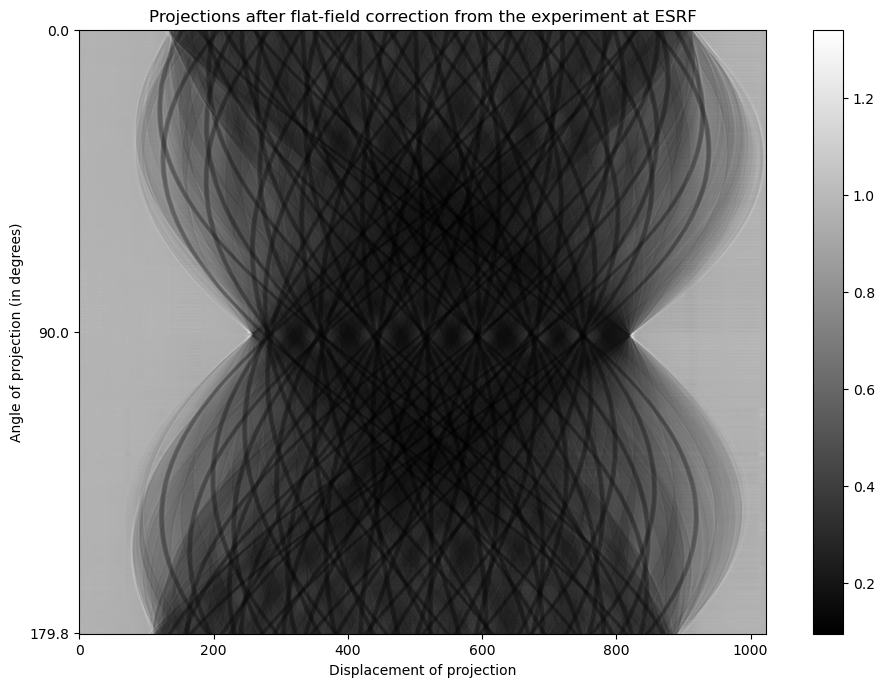

In [6]:
labels = [theta[0], theta[reference_normalised_projections.shape[0] // 2], theta[-1]];
tics = [
    0,
    reference_normalised_projections.shape[0] // 2,
    reference_normalised_projections.shape[0]-1
];
fig = plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Projections after flat-field correction from the experiment at ESRF");
fig.colorbar(imgplot);
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.pdf')
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.png', dpi=10)

In [7]:
def flatFieldCorrection(raw_projections_in_keV):
    """
    This function applies the flat-field correction on raw projections.

    :param 2D_image raw_projections_in_keV: the raw X-ray projections in keV
    :return the projections (raw_projections_in_keV) after flat-field correction
    """

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections_in_keV.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);

    return corrected_projections;

`reference_normalised_projections` (the figure above) corresponds to the data loaded from the binary file. It corresponds to $\mathbf{Proj}$, i.e. the flat-field correction has already been performed. 

We can see that when the primary spectrum is not monochromatic the measurement is the sum of several attenuation laws. We could however compute the effective monochromatic attenuation that would give the same measurement:
$$    \mathbf{I}(x,y) = \mathbf{I}_0(x,y) \; \exp\left({-\sum_j \mu_j(E_{\mathrm{eff}}) \; \mathbf{d}_j(x,y)}\right)$$
    
with $\mathbf{I}_0(x,y) = \sum_i \mathbf{R}_i \, \mathbf{N}_i$, and where $E_{\mathrm{eff}}$ corresponds to the monochromatic energy that would give the same attenuation than
the one measured. We are now able to linearise the transmission tomography data, namely $\mathbf{Proj}$, and we get the sinogram:
$$\textbf{Sino}=-\ln\left(\textbf{Proj}\right)$$

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [8]:
def removeNAN(img, border=2):
    
    restore_shape = False
    if len(img.shape) == 3:
        img.shape = [img.shape[0], img.shape[2]]
        
    inf_index = np.argwhere(np.isinf(img));
    if inf_index.shape[0]:
        simulated_sinogram[inf_index] = nan

    nan_index = np.argwhere(np.isnan(img));
    if nan_index.shape[0]:
        temp = np.pad(img, border, "edge");
        
        for index in nan_index:
            roi = temp[index[0]-border+border:index[0]+border+border+1, index[1]-border+border:index[1]+border+border+1];
            img[index[0], index[1]] = np.nanmedian(roi);

    if restore_shape:
        img.shape = [img.shape[0], 1, img.shape[1]]

    return img

In [9]:
def computeSinogramFromFlatField(normalised_projections):
    """
    This function apply the minus log normalisation
    on the projections that bave been corrected with the flat-field method.

    :param 2D_image normalised_projections: The projections after flat-field corrections
    :return the sinogram.
    """

#     # Create a temporary image to hold the sinogram
#     simulated_sinogram = copy.deepcopy(normalised_projections);

#     # Make sure no value is negative or null (because of the log function)
#     # It should not be the case, however, when the Laplacian is used to simulate
#     # phase contrast, negative values can be generated.
#     threshold = 0.000001
#     simulated_sinogram[simulated_sinogram < threshold] = threshold;

#     # Apply the minus log normalisation
#     simulated_sinogram = -np.log(simulated_sinogram);

    simulated_sinogram = tomopy.minus_log(normalised_projections)
    simulated_sinogram = removeNAN(simulated_sinogram)

    # Rescale the data taking into account the pixel size
    simulated_sinogram /= pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    # Return the new image
    return simulated_sinogram;

Compute the sinogram from the flat-field data

In [10]:
reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

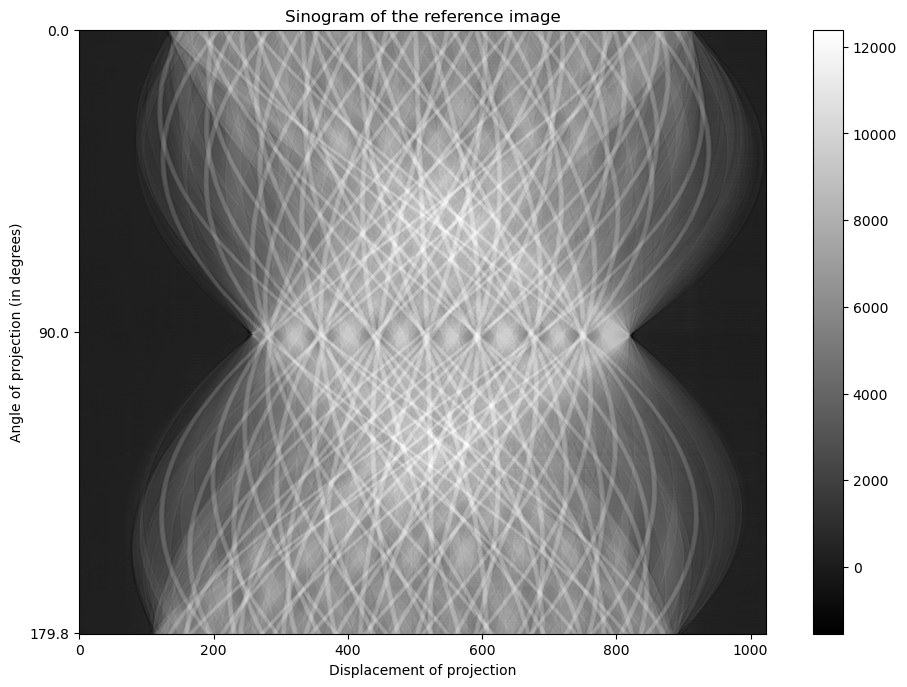

In [11]:
labels = [theta[0], theta[reference_normalised_projections.shape[0] // 2], theta[-1]];
tics = [
    0,
    reference_normalised_projections.shape[0] // 2,
    reference_normalised_projections.shape[0]-1
];
fig = plt.figure();
imgplot = plt.imshow(reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);
plt.savefig('plots/Sinogram_reference_image.pdf')
plt.savefig('plots/Sinogram_reference_image.png', dpi=10)

# CT reconstruction

Now we got a sinogram, we can reconstruct the CT slice. As we used a synchrotron, we can assume we have a parallel source. It means we can use a FBP rather than the FDK algorithm. In fact we use the gridrec algorithm, which is much faster:

Dowd BA, Campbell GH, Marr RB, Nagarkar VV, Tipnis SV, Axe L, and Siddons DP. [Developments in synchrotron x-ray computed microtomography at the national synchrotron light source](https://doi.org/10.1117/12.363725). In Proc. SPIE, volume 3772, 224–236. 1999.

In [12]:
def reconstruct(sinogram):

    restore_shape = False
    if len(sinogram.shape) == 2:

        restore_shape = True
        
        sinogram.shape = [
            sinogram.shape[0],
            1,
            sinogram.shape[1]
        ];

    # rot_center = tomopy.find_center_vo(sinogram)
    rot_center = 511.25

    CT_slice = tomopy.recon(sinogram,
                                theta_rad,
                                center=rot_center,
                                sinogram_order=False,
                                algorithm='gridrec',
                                filter_name='shepp')[0];

    if restore_shape:
        sinogram.shape = [
            sinogram.shape[0],
            sinogram.shape[2]
        ];

    CT_slice = removeNAN(CT_slice)
    
    return CT_slice

In [13]:
# CT reconstruction

reference_sinogram = np.array(computeSinogramFromFlatField(reference_normalised_projections))
reference_CT = reconstruct(reference_sinogram)

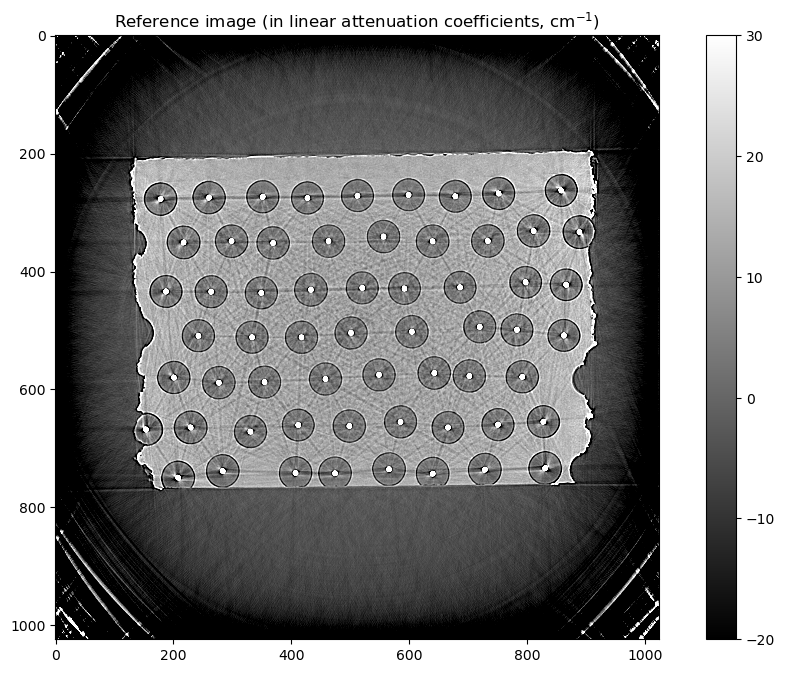

In [14]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=30, vmin=-20)
imgplot = plt.imshow(reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");
plt.savefig('plots/reference_CT_image.pdf');
plt.savefig('plots/reference_CT_image.png', dpi=10);

# Choise of objective function

![](figure_03.svg)


- Which images to compare?
    - Projections after flat-field correction: $\mathbf{Proj}$, ![](plots/Normalised_projections_from_experiment_ESRF.png)
    - Sinogram:$\mathbf{Sino}$, ![](./plots/Sinogram_reference_image.png)
    - Reconstructed CT slice ![](./plots/reference_CT_image.png)
- Which image comparison method?
    - MAE,
    - RMSE,
    - SSIM,
    - ZNCC
    - ...
- With or without normalisation?
    - min-max normalisation,
    - zero-mean, unit-variance normalisation (also known as standardisation in machine learning)

# Root mean squared error (RMSE) 

\begin{equation}
\text{RMSE}(\boldsymbol{m}, \hat{\boldsymbol{m}})= \sqrt{\frac{1}{w \; h} \sum_{q}^{h}\sum_{p}^{\text{W}} \left(m_{p,q} - \hat{m}_{p,q}\right)^2}
\label{eq:RMSE}
\end{equation}

(RMSE should be preferred when large errors must be prevented)

In [15]:
def metrics(ref, test):

    # Sometimes the CT reconstruction algorithm create NaN on
    # the top and right borders, we filter them out using
    # a median filter ignoring NaN
    test = removeNAN(test)
        
    normalised_ref = ref.flatten();
    normalised_test = test.flatten();

    if use_normalisation or metrics_type == "ZNCC":
        normalised_ref = standardisation(normalised_ref);
        normalised_test = standardisation(normalised_test);

    # Mean absolute error
    if metrics_type == "MAE":
        return mean_absolute_error(normalised_ref, normalised_test);
    # RMSE
    elif metrics_type == "RMSE":
#         MSE = np.mean(np.square(np.subtract(normalised_ref, normalised_test)))
        MSE = mean_squared_error(normalised_ref, normalised_test)
        return math.sqrt(MSE);
    # Mean relative error
    elif metrics_type == "MRE" or metrics_type == "MAPE":

        # Prevent division by zero
        denominator = np.abs(np.subtract(normalised_ref, normalised_test)) + 1e-6;
        divisor = np.abs(normalised_ref) + 1e-6;

        return np.mean(np.divide(denominator, divisor));
    elif metrics_type == "SSIM" or metrics_type == "DSSIM":
        normalised_ref.shape = [900, 1024];
        normalised_test.shape = [900, 1024];
        return (1.0 - ssim(normalised_ref, normalised_test,
                  data_range=normalised_ref.max() - normalised_ref.min())) / 2.0;
    elif metrics_type == "ZNCC":
        return (1.0 - np.mean(np.multiply(normalised_ref, normalised_test))) / 2.0;
    else:
        raise "Unknown metrics";

# Normalise the image data

Zero-mean, unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (or Z-score Normalisation) in machine learning. It is computed as follows:

$$\mathbf{m}_o=\frac{\mathbf{m}-\bar{m}}{\sigma_m}$$

where $\mathbf{m}_o$ is the image after normalisation of Image $\mathbf{m}$, $\bar{m}$ is the average pixel value of Image $\mathbf{m}$, and $\sigma_m$ its standard deviation.
After normalisation, the average pixel value is null and the standard deviation of pixel values is equal to one.

We define a function to apply this:

In [16]:
def standardisation(I):
    image = copy.deepcopy(I);

    # Sometimes the CT reconstruction algorithm create NaN on
    # the top and right borders, we filter them out using
    # a median filter ignoring NaN
    nan_index = np.argwhere(np.isnan(image));
    if nan_index.shape[0]:
        temp = np.pad(image, 1, "edge");

        for index in nan_index:
            roi = temp[index[0]-1+1:index[0]+1+2, index[1]-1+1:index[1]+1+2];
            image[index[0], index[1]] = np.nanmedian(roi);

    return (image - image.mean()) / image.std();


Normalise the reference sinogram and CT slice

In [17]:
normalised_reference_sinogram = standardisation(reference_sinogram);
normalised_reference_CT       = standardisation(reference_CT);

In [18]:
use_normalisation = True;
use_sinogram = True;

metrics_type = "RMSE";

# Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [19]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

![](../doc/3d_scene.svg)

In [20]:
detector_width_in_pixels = reference_sinogram.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(pixel_spacing_in_micrometre, pixel_spacing_in_micrometre, "micrometer");

And the source parameters (beam shape, source position)

In [21]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "m");
gvxr.usePointSource();
# gvxr.useParallelBeam();

The beam spectrum. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [22]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];
initial_energy_spectrum = copy.deepcopy(energy_spectrum)

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

Plot the beam spectrum using Matplotlib

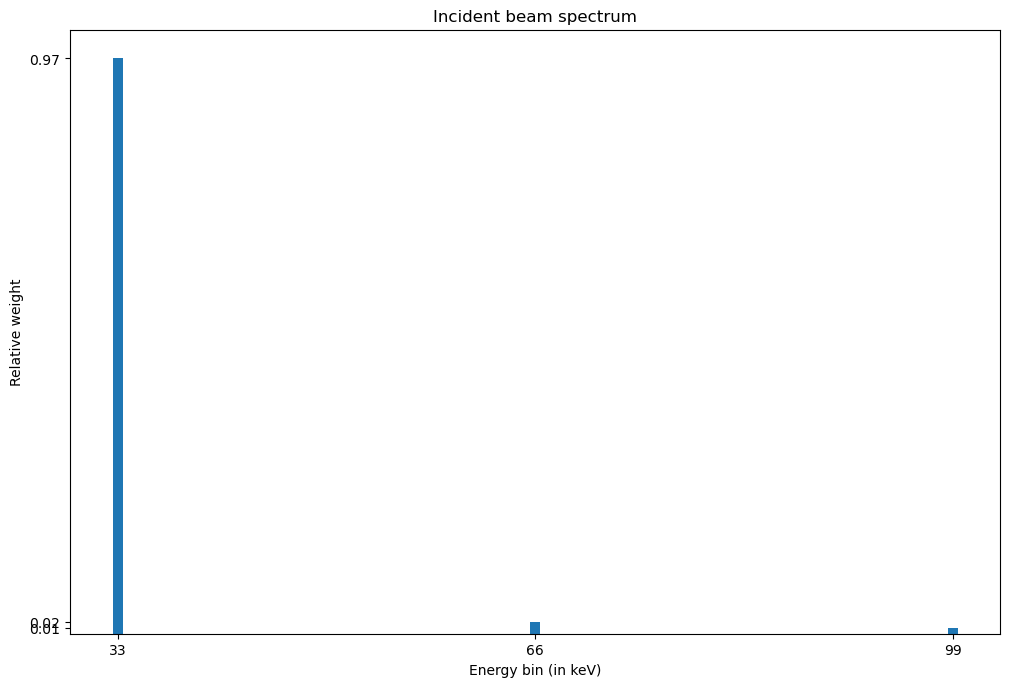

In [23]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);
plt.savefig('plots/beam_spectrum.pdf');
plt.savefig('plots/beam_spectrum.png');

The material properties (chemical composition and density)

In [24]:
fibre_material = [("Si", 0.5), ("C", 0.5)];
fibre_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_density = 4.42 # g/cm3

# The LSF

In a previous study, we experimentally measured the impulse response of the detector as the line spread function (LSF):

F.P. Vidal, J.M. Létang, G. Peix, P. Cloetens, Investigation of artefact sources in synchrotron microtomography via virtual X-ray imaging, *Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms*, Volume 234, Issue 3, 2005, Pages 333-348, ISSN 0168-583X, DOI [10.1016/j.nimb.2005.02.003](10.1016/j.nimb.2005.02.003).

We use this model during the initial steps of the registration. The LSF model will be tuned in one of the final steps of the registration.

In [25]:
def lsf(x, b2 = 54.9359, c2 = -3.58452, e2 = 6.32561e+09, f2 = 1.0):

    if hasattr(x, "__len__") == False:
        temp = x;

    else:
        temp = np.array(x);

    temp_1 = (2.0/(math.sqrt(math.pi)*e2*f2)) * np.exp(-np.square(x)/(e2*e2));
    temp_2 = 1.0 / (b2 * c2) * np.power(1+np.square(x)/(b2*b2),-1);
    temp_3 = np.power(2.0/f2+math.pi/c2, -1);
    value = (temp_1 + temp_2) * temp_3;

    return value

In [26]:
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41)/lsf(0);
lsf_kernel/=lsf_kernel.sum();

Plot the LSF using Matplotlib

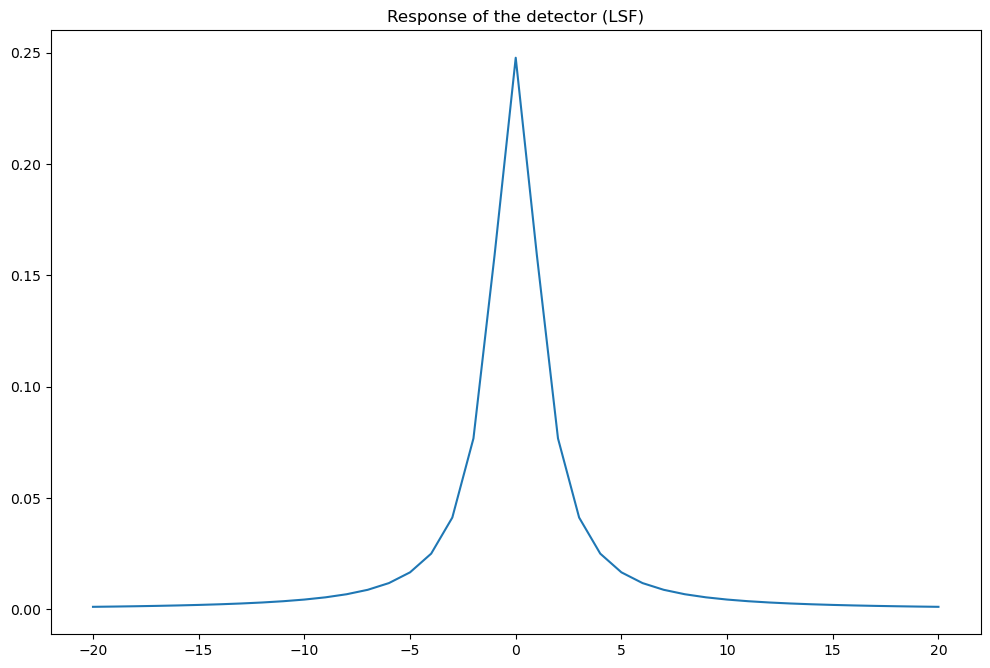

In [27]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, lsf_kernel);
plt.savefig('plots/LSF.pdf');
plt.savefig('plots/LSF.png');

## Simulate the CT acquisition

There are 7 successive steps to simulate the XCT data acquisition:

1. Set the fibre and cores geometries and material properties (Step 45)
2. Set the matrix geometry and material properties (Step 46)
3. Simulate the raw projections for each angle:
   - Without phase contrast (Line 9 of Step 49), or
   - With phase contrast (Lines 12-55 of Step 49)
4. Apply the LSF (Lines 57-60 of Step 49)
5. Apply the flat-field correction (Line 63 of Step 49)
6. Add Poison noise (Lines 67-76 of Step 49)(Lines 12-55 of Step 49)
7. Apply the minus log normalisation to compute the sinogram (Line 79 of Step 49)

Compute the raw projections and save the data. For this  purpose, we define a new function.

In [28]:
def tomographyAcquisition():
    """
    This function simulate a CT acquisition.

    :return the raw projections in keV
    """

    # Crete a new array to save every projection in default unit of energy
    raw_projections = [];

    # For each angle, simulate a projection
    for angle_id in range(0, number_of_projections):

        # Reset the transformation matrix and rotate the scnned object
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        xray_image = np.array(gvxr.computeXRayImage());

        # Add the projection
        raw_projections.append(xray_image);

    # Convert from the default unit of energy to keV
    raw_projections = np.array(raw_projections);
    raw_projections_in_keV = raw_projections / gvxr.getUnitOfEnergy("keV");

    return raw_projections_in_keV;

The function below is used to simulate a sinogram acquisition. Phase contrast in the projections can be taken into account or not. Also, Poisson noise can be added.

In [29]:
def simulateSinogram(sigma_set=None, k_set=None, name_set=None):

    global lsf_kernel;

    # Do not simulate the phase contrast using a Laplacian
    if isinstance(sigma_set, NoneType) or isinstance(k_set, NoneType) or isinstance(name_set, NoneType):

        # Get the raw projections in keV
        raw_projections_in_keV = tomographyAcquisition();

    # Simulate the phase contrast using a Laplacian
    else:

        # Create the convolution filter
        pixel_range = np.linspace(-value_range, value_range, num=int(num_samples), endpoint=True)
        laplacian_kernels = {};

        # Store the L-buffers
        L_buffer_set = {};

        # Look at all the children of the root node
        for label in ["core", "fibre", "matrix"]:
            # Get its L-buffer
            L_buffer_set[label] = getLBuffer(label);

        # Create blank images
        raw_projections_in_keV = np.zeros(L_buffer_set["fibre"].shape);
        phase_contrast_image = np.zeros(L_buffer_set["fibre"].shape);

        for label, k, sigma in zip(name_set, k_set, sigma_set):
            laplacian_kernels[label] = k * laplacian(pixel_range, sigma);

            for z in range(phase_contrast_image.shape[0]):
                for y in range(phase_contrast_image.shape[1]):
                    phase_contrast_image[z][y] += ndimage.convolve((L_buffer_set[label])[z][y], laplacian_kernels[label], mode='wrap');

        for energy, photon_count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):

            # Create a blank image
            attenuation = np.zeros(L_buffer_set["fibre"].shape);

            # Look at all the children of the root node
            # for label in ["core", "fibre", "matrix"]:
            for label in ["core", "fibre", "matrix"]:
                # Get mu for this object for this energy
                mu = gvxr.getLinearAttenuationCoefficient(label, energy, "keV");

                # Compute sum mu * x
                attenuation += L_buffer_set[label] * mu;

            # Store the projection for this energy channel
            raw_projections_in_keV += energy * photon_count * np.exp(-attenuation);

        # Apply the phase contrast
        raw_projections_in_keV -= phase_contrast_image;

    # Apply the LSF line by line
    if not isinstance(lsf_kernel, NoneType):
        for z in range(raw_projections_in_keV.shape[0]):
            for y in range(raw_projections_in_keV.shape[1]):
                raw_projections_in_keV[z][y] = ndimage.convolve(raw_projections_in_keV[z][y], lsf_kernel, mode='wrap');

    # Flat-field correction
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    normalised_projections[normalised_projections < 0] = 0;

    # Add noise
    if not isinstance(bias, NoneType) and not isinstance(gain, NoneType) and not isinstance(scale, NoneType):

        map = (normalised_projections + (bias + 1)) * gain;
        temp = np.random.poisson(map).astype(float);
        temp /= gain;
        temp -= bias + 1;

        # Noise map
        noise_map = (normalised_projections - temp) * scale;
        normalised_projections += noise_map;

    # Linearise
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);

    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

The function below is the objective function used to register the matrix.

![](pipeline-matrix.svg)

In [30]:
def setMatrix(apGeneSet):
    """This function loads a cube in the GPU memory. The cube represents
    the Ti90Al6V4 matrix.

    apGeneSet[0] is a number between -0.5 and 0.5, related to the translation vector (X component) of the cube. It can be interpreted as a percentage of the detector width.
    apGeneSet[1] is the same as apGeneSet[0], but related to the Y component of the translation vector.
    apGeneSet[2] is a number between -0.5 and 0.5, related to the rotation angle in degrees
    apGeneSet[3] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of the detector width.
    apGeneSet[4] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of apGeneSet[3].
    """

    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph();

    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 180.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);

    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * w;
    gvxr.scaleNode("matrix", w, 815, h);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Set the matrix's material properties
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("matrix");

In [31]:
def fitnessFunctionCube(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;

    global reference_sinogram;
    global centroid_set;
    global use_fibres;

    global core_radius;
    global fibre_radius;

    # Load the matrix geometrical properties from x
    setMatrix(x);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
   
    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;

#         gvxr.saveSTLfile("matrix", "outputs/matrix_" + str(best_fitness_id) + ".stl");

        # Reconstruct the CT slice
        simulated_CT = reconstruct(simulated_sinogram)

        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        imsave("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".tif",
                simulated_sinogram.astype(np.single));

        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT.astype(np.single))

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [32]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/cube.dat"):
    matrix_geometry_parameters = np.loadtxt("outputs/cube.dat");
# Perform the registration using CMA-ES
else:
    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "cube_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = [5*[-0.5], 5*[0.5]];

    es = cma.CMAEvolutionStrategy([0.0, 0.0, 0.0, 0.256835938, 0.232903226], 0.5, opts);
    es.optimize(fitnessFunctionCube);

    matrix_geometry_parameters = copy.deepcopy(es.result.xbest);
    np.savetxt("outputs/cube.dat", matrix_geometry_parameters, header='x,y,rotation_angle,w,h');
    
    # Release memory
    del es;

# Apply the result of the registration

In [33]:
# Save the result
setMatrix(matrix_geometry_parameters);

# Translation vector
x = matrix_geometry_parameters[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
y = matrix_geometry_parameters[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;
matrix_centre = [x ,y]

# Rotation angle
rotation_angle_in_degrees = (matrix_geometry_parameters[2] + 0.5) * 180.0;

# Scaling factors
w = (matrix_geometry_parameters[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
h = (matrix_geometry_parameters[4] + 0.5) * w;
matrix_size = [w, h]

print("Matrix");
print("\tposition:", x, y, "um");
print("\trotation:", rotation_angle_in_degrees, "deg");
print("\tsize:", w, h, "um");

Matrix
	position: -57.82437693235829 -24.522985880475392 um
	rotation: 90.39367848429472 deg
	size: 1448.2387879975524 1067.4433422436286 um


# Simulate the correspond CT acquisition

In [34]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set = []
ZNCC_label_set = []
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Matrix")
print("ZNCC matrix registration:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC matrix registration: 72.21


In [35]:
def plotSetOfZNCC(ZNCC_set, ZNCC_label_set):
    fig = plt.figure()
    plt.bar(ZNCC_label_set, ZNCC_set)
    plt.ylim([65,95])
    plt.xticks(rotation=45, ha='right')
#     plt.yscale('log')
    plt.ylabel("ZNCC in (%)")

    for i, zncc in enumerate(ZNCC_set):
        plt.text(i, zncc, "{:.2f}".format(zncc) + "%", horizontalalignment='center', verticalalignment='bottom')
    plt.show()

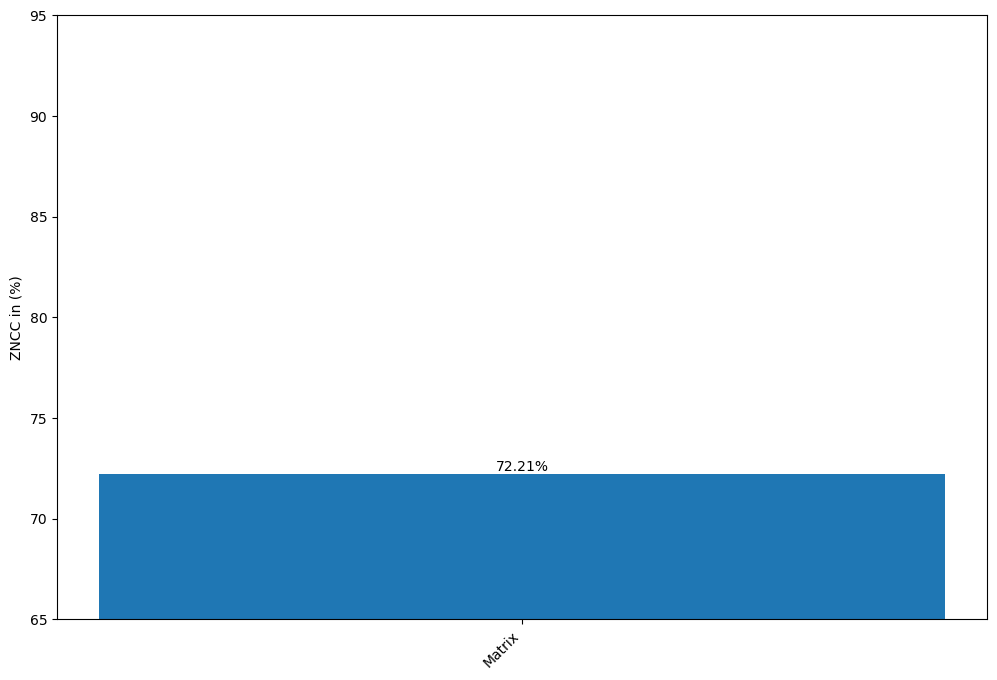

In [36]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

In [37]:
def createAnimation(aPrefix, anOutputFile):
    # Find all the images from the output directory
    files = sorted(
        glob.glob(aPrefix + "[0-9]*.tif"))

    # Store the images
    registration_image_set = [];

    # Create the GIF file
    with imageio.get_writer(anOutputFile, mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i in range(len(files)):
            # Create the filenames
            input_fname = aPrefix + str(i) + ".tif";
            png_filename_set.append(aPrefix + str(i) + ".png");

            # Open the TIFF file
            narray = imread(input_fname);

            offset = 60;
            roi_ref = reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];

            narray = standardisation(narray);
            registration_image_set.append(narray);

            # Create the figure
            fig, axs = plt.subplots(3, 3)

            # Dispay the reference, registration and error map
            fig.suptitle('Registration: Result ' + str(i+1) + "/" + str(len(files)))
            plt.tight_layout();
            norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

            comp_equalized = compare_images(normalised_reference_CT, narray, method='checkerboard');

            roi_normalised_ref = normalised_reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_compare = comp_equalized[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];


            # Reference
            axs[0, 0].set_title("Reference image");
            axs[0, 0].imshow(normalised_reference_CT, cmap="gray", norm=norm);
            axs[1, 0].imshow(roi_normalised_ref, cmap="gray", norm=norm);
            axs[2, 0].axis('off');

            # Registration
            axs[0, 1].set_title("Simulated CT slice after automatic registration");
            axs[0, 1].imshow(narray, cmap='gray', norm=norm);
            axs[1, 1].imshow(roi_normalised_sim, cmap="gray", norm=norm);

            y_ref = np.diag(roi_ref)
            y_test = np.diag(roi_sim)
            len_y = len(roi_ref)

            zero_offset = round(57.32 + (63.64 - 57.32) / 2.0)
            x = np.array(range(len_y)).astype(float)
            x -= zero_offset + 0.5
            x = x * math.sqrt(2.0 * pixel_spacing_in_micrometre * pixel_spacing_in_micrometre)

            axs[2, 1].set_title("Diagonal profiles");
            axs[2, 1].plot(x, y_ref, label="Reference");
            axs[2, 1].plot(x, y_test, label="Simulated");
            axs[2, 1].set_xlabel("Distance along profile (in $\mathrm{\mu}$m)")
            axs[2, 1].set_ylabel("Linear attenuation coefficients\n(in cm$^{-1}$)")
            # axs[2, 1].plot(np.diag(roi_ref) - np.diag(roi_sim), label="Error");
            axs[2, 1].legend();
    
            # Error map
            ZNCC = 100.0 * np.mean(np.multiply(normalised_reference_CT, narray));
            axs[0, 2].set_title("Checkboard comparison between\nthe reference and simulated images\nZNCC: " + "{:.2f}".format(ZNCC));
            axs[0, 2].imshow(comp_equalized, cmap='gray', norm=norm);
            axs[1, 2].imshow(roi_normalised_compare, cmap='gray', norm=norm);
            axs[2, 2].axis('off');

            plt.tight_layout();

            # Save the figure as a PNG file
            plt.savefig(png_filename_set[i])

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread(png_filename_set[i])
            writer.append_data(image)

            # Delete the PNG file
            os.remove(png_filename_set[i]);

        for i in range(15):
            writer.append_data(image)

    return registration_image_set, image;

In [38]:
if not os.path.exists("plots/cube_registration.gif"):
    cube_registration_image_set, image = createAnimation("outputs/cube_simulated_CT_",
                'plots/cube_registration.gif');

![](plots/cube_registration.gif)

# Find the centre of fibres

![](pipeline-centres.svg)

# Find circles to identify the centre of fibres

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT. We blur it using a bilateral filter (an edge-preserving smoothing filter).

## Convert the image to UINT

We first create a function to convert images in floating point numbers into UINT.

In [39]:
def float2uint8(anImage, min_threshold = None, max_threshold = None):
    
    uchar_image = copy.deepcopy(anImage);

    if isinstance(min_threshold, NoneType):
        min_threshold = np.min(uchar_image);

    if isinstance(max_threshold, NoneType):
        max_threshold = np.max(uchar_image);
        
    uchar_image[uchar_image < min_threshold] = min_threshold;
    uchar_image[uchar_image > max_threshold] = max_threshold;

    uchar_image -= min_threshold;
    uchar_image /= max_threshold - min_threshold;
    uchar_image *= 255;
    
    return uchar_image.astype(np.uint8);

We blur the CT scan using a bilateral filter. It preserves edges.

In [40]:
uint8_reference_CT = float2uint8(reference_CT, 0, 300);
blurred_reference_CT = cv2.bilateralFilter(uint8_reference_CT, 9, 75, 75);

## Apply the Hough transform

As the fibres and the cores correspond to circles in the CT images, the obvious technique to try is the Hough Circle Transform (HCT). It is a feature extraction technique used in image analysis that can output a list of circles (centres and radii). 

In [41]:
circles = cv2.HoughCircles(blurred_reference_CT, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=150, param2=5, minRadius=5, maxRadius=15);

## Overlay the detected circles on the top of the image

In [42]:
cimg = cv2.cvtColor(float2uint8(reference_CT, 0, 50), cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2);
    
    # draw the center of the circle
    cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3);

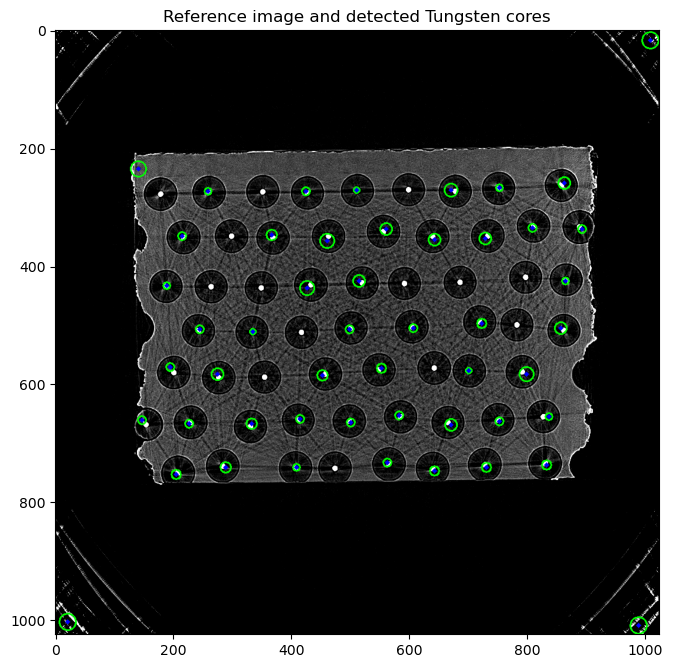

In [43]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_Hough_transform.pdf');
plt.savefig('plots/fibre_detection_using_Hough_transform.png');

13 fibres were missed and many centres were misplaced. Controlling the meta-parameters of the algorithm can be difficult to employ in a fully-automatic registration framework. We will use another technique to register the fibres, the popular Otsu's method. It creates a histogram and uses a heuristic to determine a threshold value.

In [44]:
# Convert the numpy array in float32 into uint, then into a SITK image
volume = sitk.GetImageFromArray(blurred_reference_CT);
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 93.0


In [45]:
# Convert the numpy array in float32 into uint, then into a SITK image
volume = sitk.GetImageFromArray(blurred_reference_CT);
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 93.0


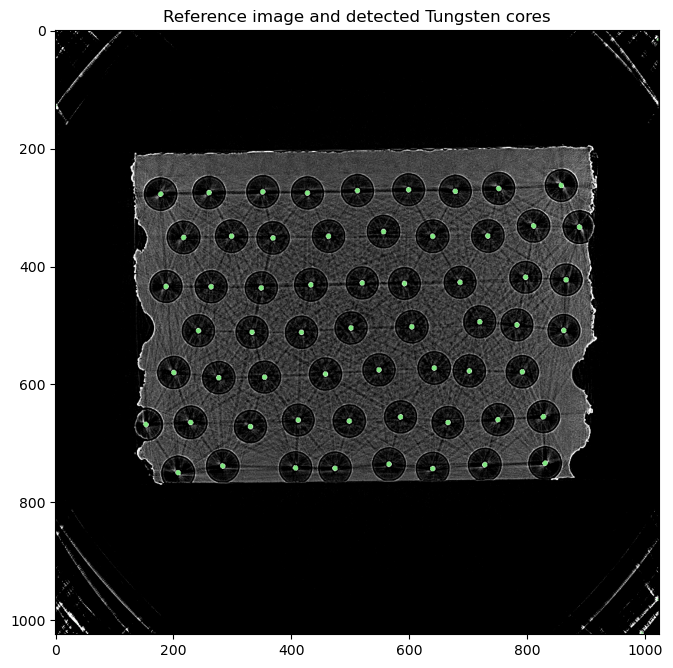

In [46]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, seg)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method.png');

In [47]:
sitk.WriteImage(seg, "outputs/cores_segmentation.mha", useCompression=True);

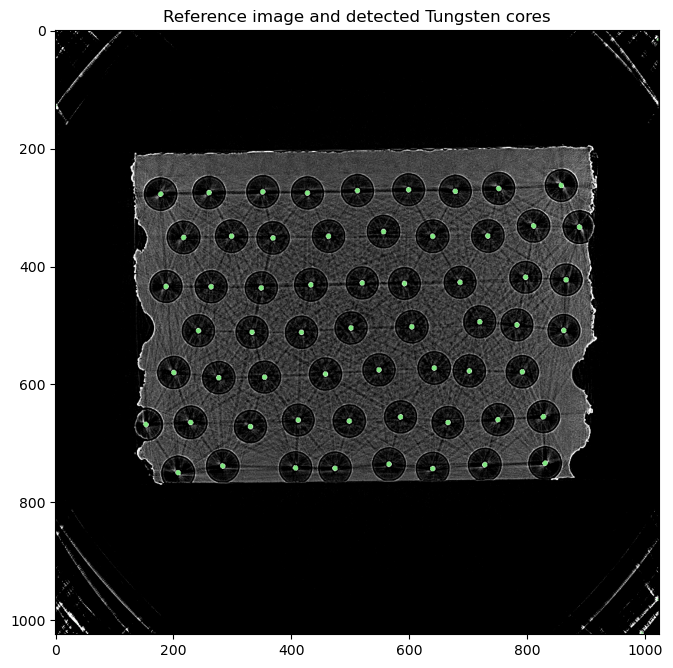

In [48]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, seg)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method.png');

## Clean up

In [49]:
# Clean-up using mathematical morphology
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(seg, [3, 3, 3])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [3, 3, 3])

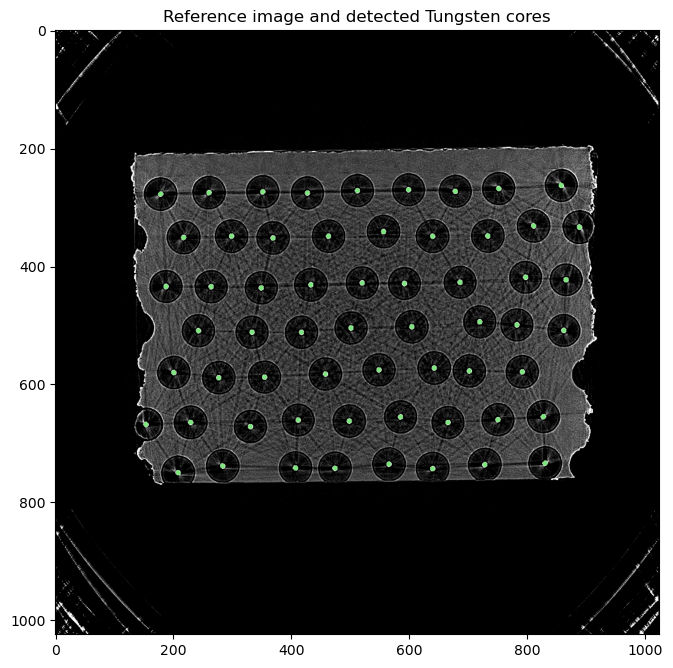

In [50]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, cleaned_thresh_img)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.png');

## Mark each potential tungsten core with unique label

In [51]:
core_labels = sitk.ConnectedComponent(cleaned_thresh_img);

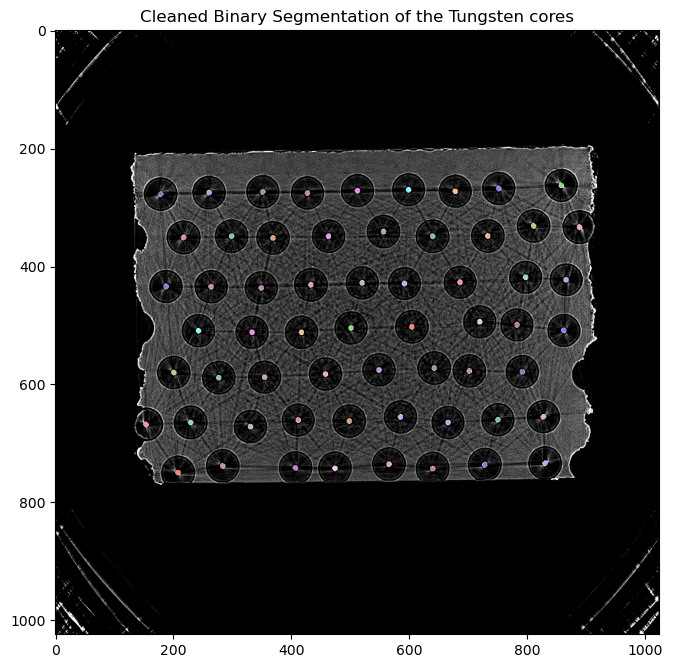

In [52]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, core_labels)));
plt.title("Cleaned Binary Segmentation of the Tungsten cores");
plt.savefig('plots/fibre_detection_with_label_overlay.pdf');
plt.savefig('plots/fibre_detection_with_label_overlay.png');

## Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects. For each labelled tungsten core, we extract the centroid. Note that sizes and positions are given in millimetres.

In [53]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(core_labels)

In [54]:
centroid_set = [];

for i in shape_stats.GetLabels():
    centroid_set.append(cleaned_thresh_img.TransformPhysicalPointToIndex(shape_stats.GetCentroid(i)));

We now have a list of the centres of all the fibres that can be used as a parameter of the function below to create the cylinders corresponding to the cores and the fibres. 
For each core, a cylinder is creatd and translated:
```python
        gvxr.emptyMesh("core_"  + str(i));
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");
        gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");
```
For each fibre, another cylinder is created and translated:
```python
        gvxr.emptyMesh("fibre_"  + str(i));
        gvxr.makeCylinder("fibre_"  + str(i), number_of_sectors, 815.0,  fibre_radius, "micrometer");
        gvxr.translateNode("fibre_"  + str(i), y, 0.0, x, "micrometer");
```
The fibre's cylinder is hollowed to make space for its core:
```python
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));
```

## Adding the fibres

The radius of a tungsten core is 30 / 2 um. The pixel spacing is 1.9 um. The radius in number of pixels is $15/1.9  \approx  7.89$. The area of a core is $(15/1.9)^2  \pi  \approx 196$ pixels.

In [55]:
def setFibres(aCentroidSet):
    """This function loads a cylinders in the GPU memory.
    Some are hollow and represent the fibres, some are not and
    correspond to the cores.

    :param array aCentroidSet: a list of cylinder centres.
    """

    global core_radius;
    global fibre_radius;

    # Create empty geometries
    gvxr.emptyMesh("fibre");
    gvxr.emptyMesh("core");

    # Number of sectors to approximate cylinders with triangle meshes
    # It controls the accuracy of the meshes.
    number_of_sectors = 100;

    # Process all the centres from the input list
    for i, cyl in enumerate(aCentroidSet):

        # Convert the centre position from 2D image coordinates in 3D world coordinates
        x = pixel_spacing_in_micrometre * -(cyl[0] - reference_CT.shape[1] / 2 + 0.5);
        y = pixel_spacing_in_micrometre * (cyl[1] - reference_CT.shape[0] / 2 + 0.5);

        # Create empty geometries (is it needed?)
        gvxr.emptyMesh("fibre_" + str(i));
        gvxr.emptyMesh("core_" + str(i));

        # Create the two corresponding cylinders (fibre and core)
        gvxr.makeCylinder("fibre_" + str(i), number_of_sectors, 815.0, fibre_radius, "micrometer");
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

        # Translate the two cylinders to the position of their centre
        gvxr.translateNode("fibre_" + str(i), y, 0.0, x, "micrometer");
        gvxr.translateNode("core_" + str(i), y, 0.0, x, "micrometer");

        # Apply the local transformation matrix (so that we could save the corresponding STL files)
        gvxr.applyCurrentLocalTransformation("fibre_" + str(i));
        gvxr.applyCurrentLocalTransformation("core_" + str(i));

        # Subtract the fibre from the matrix
        gvxr.subtractMesh("matrix", "fibre_" + str(i));

        # Subtract the core from the fibre
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));

        # Save the corresponding STL files
        # gvxr.saveSTLfile("fibre_" + str(i), "Tutorial2/outputs/fibre_" + str(i) + ".stl");
        # gvxr.saveSTLfile("core_" + str(i),  "Tutorial2/outputs/core_"  + str(i) + ".stl");

        # Add the mesh of the current fibre to the overall fibre mesh
        gvxr.addMesh("fibre", "fibre_" + str(i));

        # Add the mesh of the current core to the overall core mesh
        gvxr.addMesh("core", "core_"  + str(i));

    # Set the mesh colours (for the interactive visualisation)
    gvxr.setColor("fibre", 1.0, 0.0, 0.0, 1.0);
    gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

    # Set the fibre's material properties
    # gvxr.setLinearAttenuationCoefficient("fibre", fibre_mu, "cm-1");
    gvxr.setCompound("fibre", "SiC");
    gvxr.setDensity("fibre", fibre_density, "g/cm3");

    # Set the core's material properties
    # gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
    gvxr.setElement("core", "W");

    # Add the fibres and cores to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fibre");

In [56]:
setMatrix(matrix_geometry_parameters);
setFibres(centroid_set);

In [57]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

In [58]:
# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("matrix registration with fibres")

print("ZNCC matrix registration with fibres:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC matrix registration with fibres: 69.74


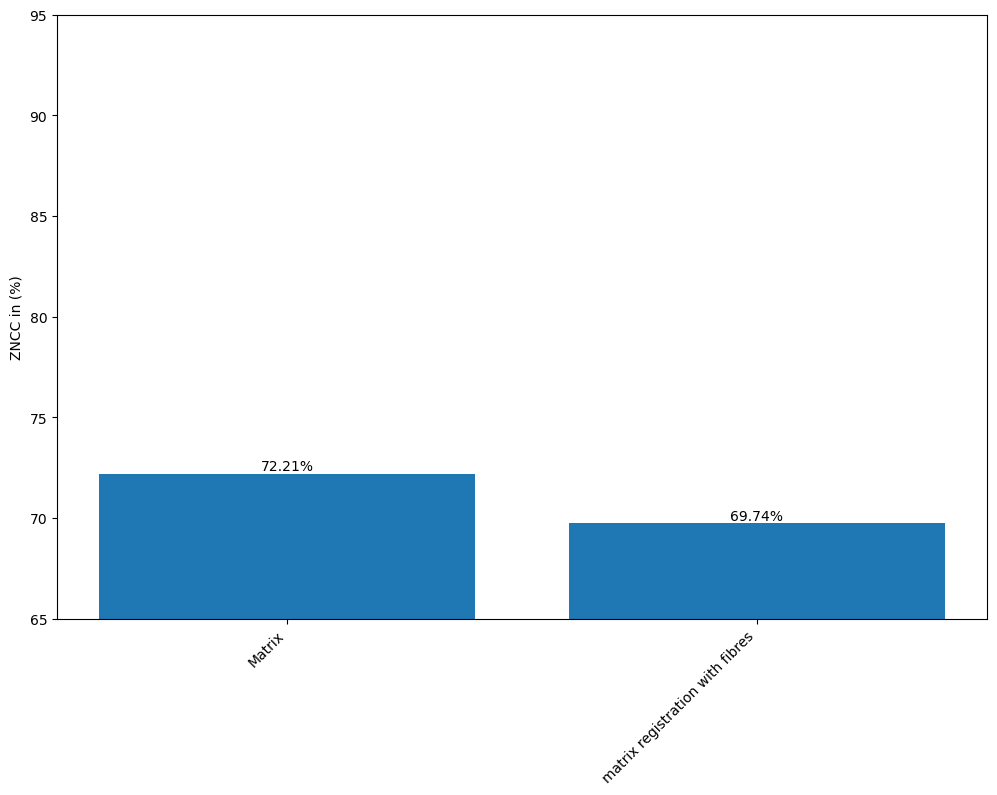

In [59]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

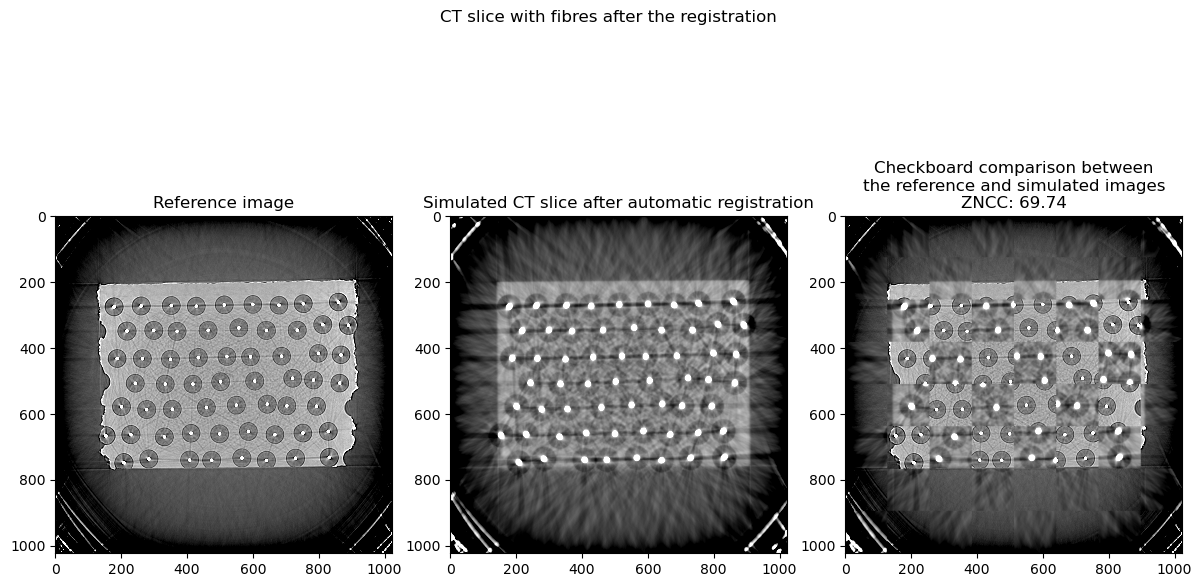

In [60]:
norm2 = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm2);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm2);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm2);

plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.pdf');
plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.png');

# Optmise core and fibre radii

![](pipeline-radii1.svg)

The function below is the objective function used to optimise the radii of the cores and fibres.

In [61]:
def fitnessFunctionFibres(x):
    global best_fitness;
    global best_fitness_id;
    global fibre_radius;
    global core_radius;
    global prefix;

    # Get the radii
    fibre_radius = x[0];
    core_radius = fibre_radius * x[1];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = reconstruct(simulated_sinogram)
        
        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [62]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre1_radii.dat"):
    temp = np.loadtxt("outputs/fibre1_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre1_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

In [63]:
if not os.path.exists("plots/fibre1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre1_simulated_CT_",
                'plots/fibre1_registration.gif');

![](plots/fibre1_registration.gif)

## Apply the result of the registration

In [64]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);


# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Optimise core and fibre radii")

print("ZNCC optimise core and fibre radii:",
      "{:.2f}".format(ZNCC_set[-1]));

Core diameter: 15 um
Fibre diameter: 103 um
ZNCC optimise core and fibre radii: 88.04


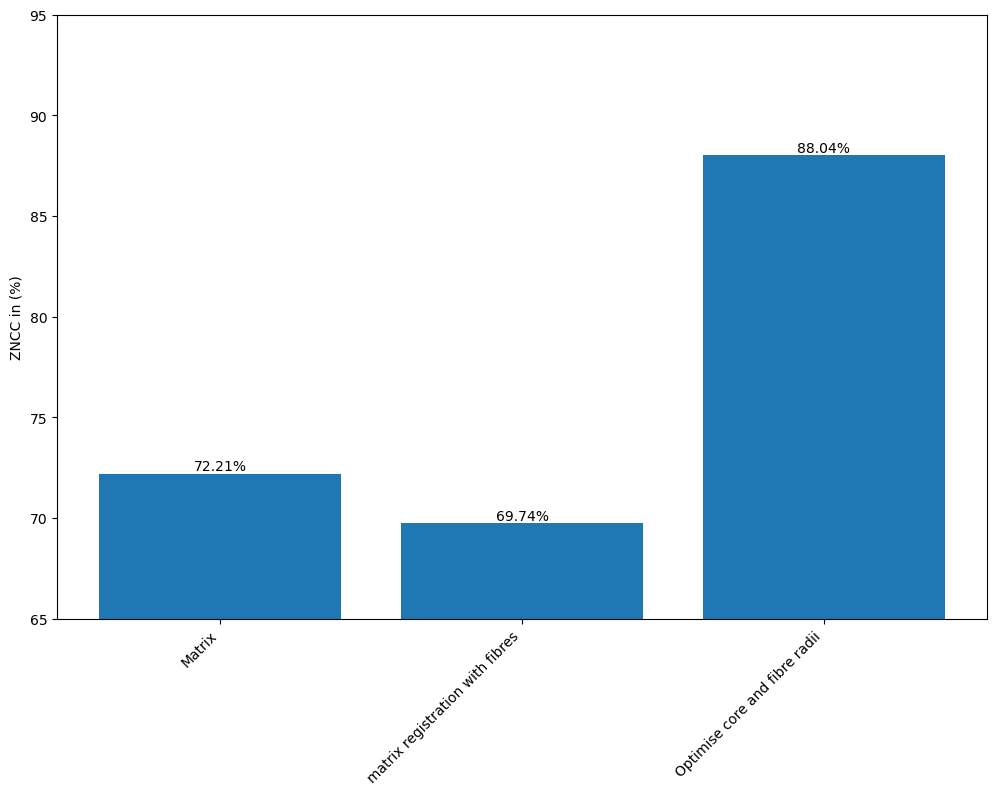

In [65]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

# Recentre the cores and fibres

![](pipeline-recentre.svg)

Each fibre is extracted from both the reference CT slice and simulated CT slice. The displacement between the corresponding fibres is computed to maximise the ZNCC between the two. The centre of the fibre is then adjusted accordingly.

In [66]:
def refineCentrePositions(centroid_set, reconstruction_CT_fibres):

    # Exhaustive local search to refine the centre of each cylinder
    roi_length = 40;
    new_centroid_set = [];
    for i, cyl in enumerate(centroid_set):

        centre = [
            cyl[0],
            cyl[1]
        ];

        # extract ROI from reference image
        reference_image = copy.deepcopy(reference_CT[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

        # Normalise ROI
        reference_image = standardisation(reference_image);

        best_ZNCC = -1;
        best_x_offset = 0;
        best_y_offset = 0;

        for y in range(-10, 11):
            for x in range(-10, 11):

                centre = [
                    cyl[0] + x,
                    cyl[1] + y
                ];

                # extract ROI from test image
                test_image = copy.deepcopy(reconstruction_CT_fibres[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

                # Normalise ROI
                test_image = standardisation(test_image);

                # Compare the ROIs
                zncc = np.mean(np.multiply(reference_image.flatten(), test_image.flatten()));

                if best_ZNCC < zncc:
                    best_ZNCC = zncc;
                    best_x_offset = x;
                    best_y_offset = y;

        # Correct the position of the centre of the fibre
        new_centroid_set.append([cyl[0] - best_x_offset, cyl[1] - best_y_offset]);

    return new_centroid_set;

In [67]:
centroid_set = refineCentrePositions(centroid_set, normalised_simulated_CT);

## Applying the result of recentring

In [68]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Recentre the cores and fibres")

print("ZNCC Recentre the cores and fibres:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC Recentre the cores and fibres: 90.98


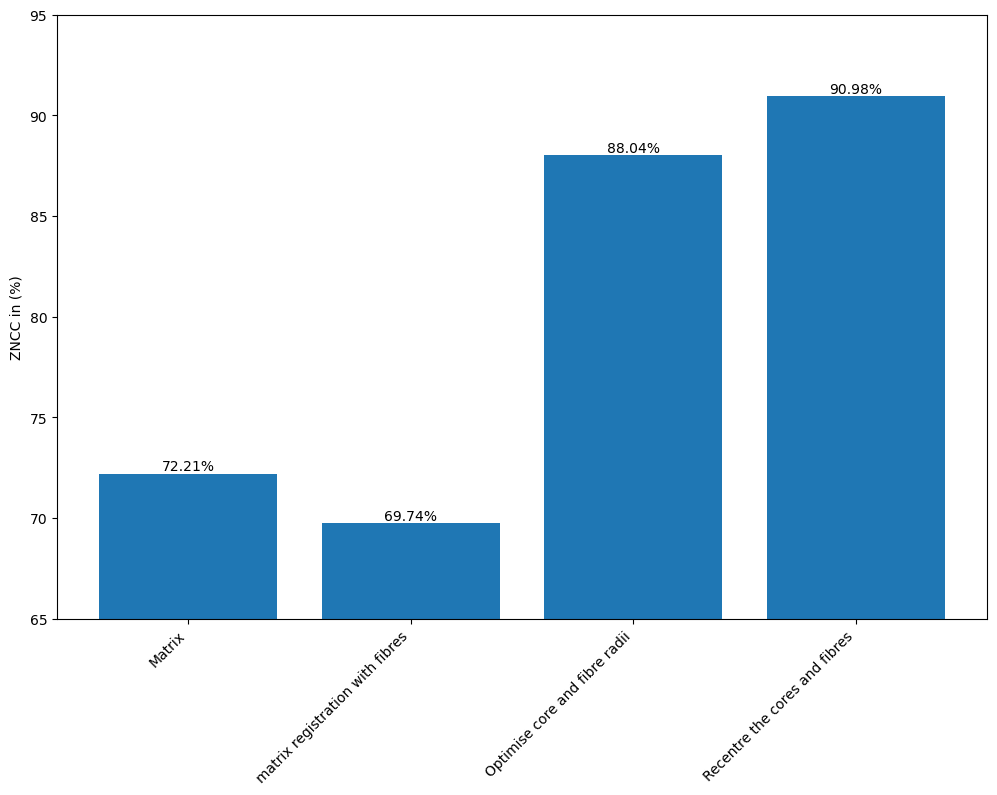

In [69]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

# Reoptmise core and fibre radii

![](pipeline-radii2.svg)

After recentring the centres, another run of optimisation is executed to refine the radii of the fibres and cores.

In [70]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre3_radii.dat"):
    temp = np.loadtxt("outputs/fibre3_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre3_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre3_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

In [71]:
if not os.path.exists("plots/fibre3_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre3_simulated_CT_",
                'plots/fibre3_registration.gif');

![](./plots/fibre3_registration.gif)

## Apply the result of the registration

In [72]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 15 um
Fibre diameter: 104 um


In [73]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Re-optimise core and fibre radii")

print("ZNCC re-optimise core and fibre radii:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC re-optimise core and fibre radii: 89.74


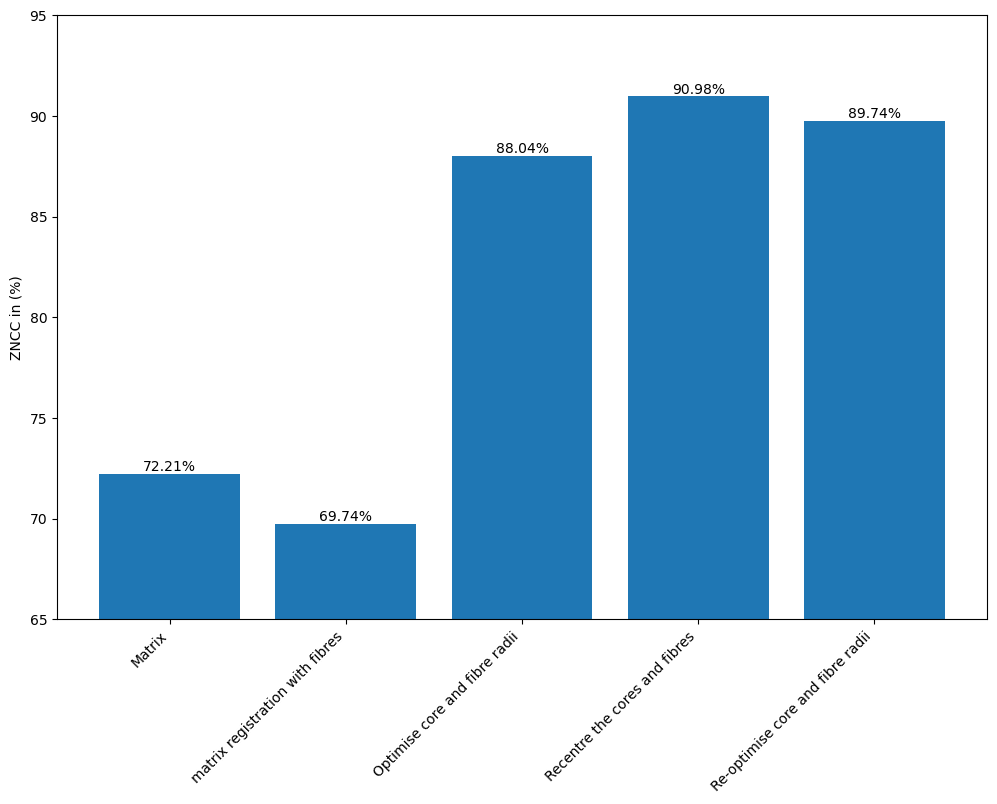

In [74]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

# Optmise beam spectrum

![](pipeline-beam.svg)

In [75]:
def fitnessHarmonics(x):

    global energy_spectrum;
        
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    energy_33_keV = x[0];
    first_order_harmonics = x[1];
    second_order_harmonics = x[2];

    # Normalise the beam spectrum
    total = energy_33_keV + first_order_harmonics + second_order_harmonics;
    energy_33_keV /= total;
    first_order_harmonics /= total;
    second_order_harmonics /= total;

    # The beam specturm. Here we have a polychromatic beam.
    gvxr.resetBeamSpectrum();
    energy_spectrum = [(33, energy_33_keV, "keV"), (66, first_order_harmonics, "keV"), (99, second_order_harmonics, "keV")];
    
    for energy, percentage, unit in energy_spectrum:
        gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

    # Compute the objective value (no normalisation here)
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = reconstruct(simulated_sinogram)

        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", np.array(x) / total, header='33keV,66keV,99keV');

        best_fitness_id += 1;

    return objective

In [76]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/spectrum1.dat"):
    temp = np.loadtxt("outputs/spectrum1.dat");

    # The beam specturm. Here we have a polychromatic beam.
    energy_spectrum = [(33, temp[0], "keV"), (66, temp[1], "keV"), (99, temp[2], "keV")];

# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [0.97, 0.2, 0.1];
    bounds = [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "spectrum1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    # Make sure the normalisation is disable
    old_normalisation = use_normalisation;
    use_normalisation = False;
    
    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessHarmonics);

    use_normalisation = old_normalisation;

    total = es.result.xbest[0] + es.result.xbest[1] + es.result.xbest[2];
    energy_spectrum = [(33, es.result.xbest[0] / total, "keV"), (66, es.result.xbest[1] / total, "keV"), (99, es.result.xbest[2] / total, "keV")];

    np.savetxt("outputs/spectrum1.dat", [es.result.xbest[0] / total, es.result.xbest[1] / total, es.result.xbest[2] / total], header='weight of main energy,weight of first order harmonics,weight of second order harmonics');
    
    # Release memory
    del es;

In [77]:
if not os.path.exists("plots/spectrum1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/spectrum1_simulated_CT_",
                'plots/spectrum1_registration.gif');

![](./plots/spectrum1_registration.gif)

In [78]:
# Apply the result of the registration
gvxr.resetBeamSpectrum();
for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

In [79]:
for channel in energy_spectrum:
    print(channel);

(33, 0.9648806520241529, 'keV')
(66, 0.0006186470109439554, 'keV')
(99, 0.03450070096490309, 'keV')


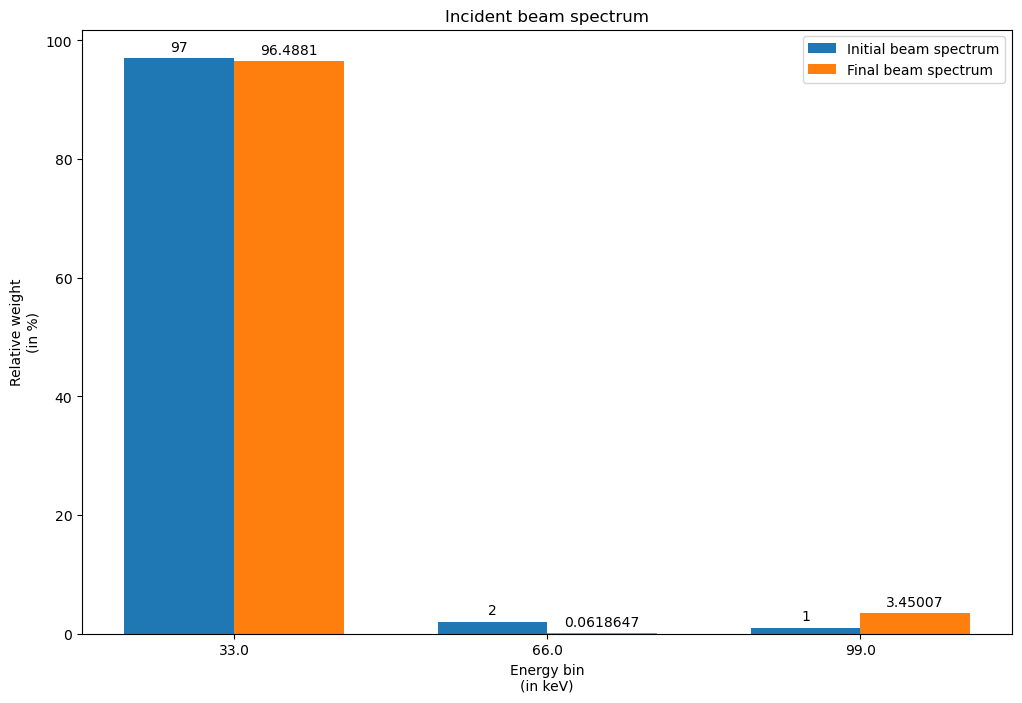

In [80]:
fig, ax = plt.subplots()

plt.title("Incident beam spectrum");
plt.xlabel("Energy bin\n(in keV)");
plt.ylabel("Relative weight\n(in %)");

energies_in_keV = [];
weights = [];

for energy, percentage, unit in initial_energy_spectrum:
    weights.append(100 * percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

# plt.xticks(energies_in_keV);
# plt.yticks(weights);

x = np.arange(len(energies_in_keV))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width / 2, weights, width, label='Initial beam spectrum')


energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(100 * percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

rects2 = ax.bar(x + width/2, weights, width, label='Final beam spectrum')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(energies_in_keV)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

plt.savefig('plots/beam_spectrum.pdf');
plt.savefig('plots/beam_spectrum.png');

In [81]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Beam spectrum")

print("ZNCC beam spectrum:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC beam spectrum: 91.18


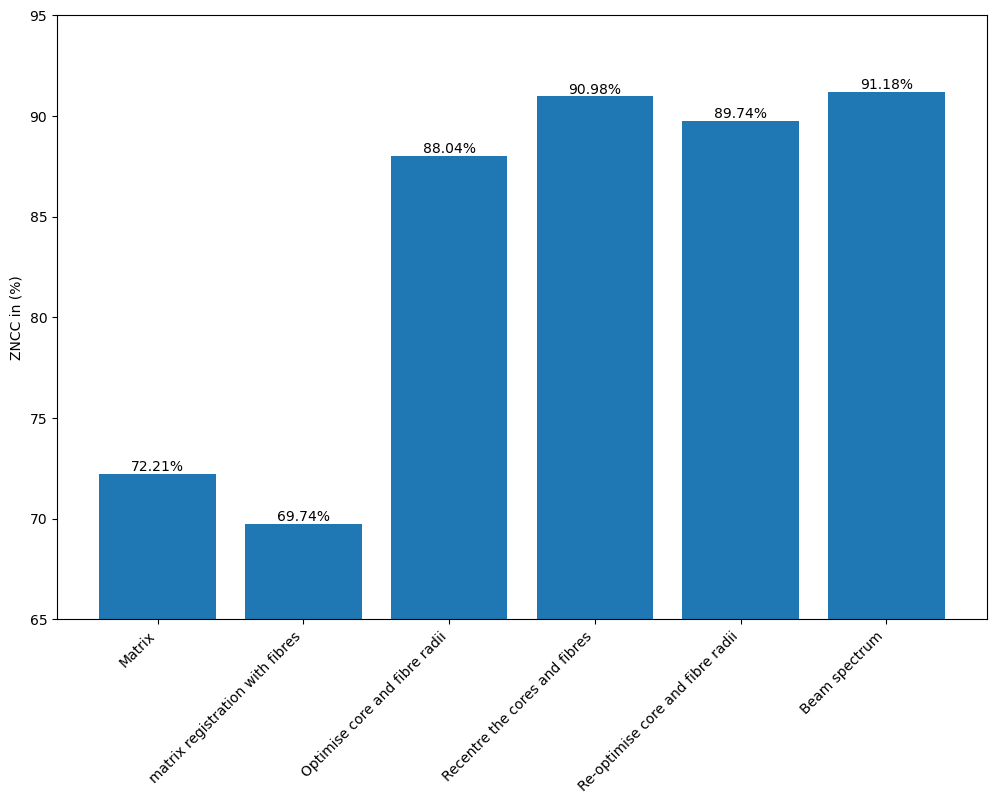

In [82]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

# Optimisation of the phase contrast and the radii

In [83]:
def laplacian(x, sigma):
    """
    This function create a Laplacian kernel with

    $$ g''(x) = \left(\frac{x^2}{\sigma^4} - \frac{1}{\sigma^2}\right) \exp\left(-\frac{x^2}{2\sigma^2}\right) $$
    
    :param array x: 
    :param float sigma:
    :return the convolution kernel
    """
    
    return (np.power(x, 2.) / math.pow(sigma, 4) - 1. / math.pow(sigma, 2)) * np.exp(-np.power(x, 2.) / (2. * math.pow(sigma, 2)));

In [84]:
def getLBuffer(object):

    """
    This function compute the L-buffer of the object over all the angles
    
    :param str object: the name of the object 
    :return the L-buffer over all the angles
    """

    # An empty L-buffer
    L_buffer = [];

    # Get the line of L-buffer for each angle
    for angle_id in range(0, number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        line_of_L_buffer = np.array(gvxr.computeLBuffer(object));

        # Add the projection
        L_buffer.append(line_of_L_buffer);

    # Return as a numpy array
    return np.array(L_buffer);

In [85]:
def fitnessFunctionLaplacian(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global fibre_radius;
    global core_radius;

    sigma_core = x[0];
    k_core = x[1];
    sigma_fibre = x[2];
    k_fibre = x[3];
    sigma_matrix = x[4];
    k_matrix = x[5];
    core_radius = x[6];
    fibre_radius = x[7];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = reconstruct(simulated_sinogram)

        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');
    
        best_fitness_id += 1;

    return objective

In [86]:
def getNewShape(image):
    remove_index = False
    new_shape = []
    
    for idx in image.shape:
        if idx == 1:
            remove_index = True
        else:
            new_shape.append(idx)

    return remove_index, new_shape

def metrics(ref, test):

#     ref_remove_index, ref_new_shape = getNewShape(ref)
    test_remove_index, test_new_shape = getNewShape(test)
    
    if test_remove_index:
        temp_test_image = copy.deepcopy(test)
        temp_test_image.shape = test_new_shape
    else:
        temp_test_image = test
    
    # Sometimes the CT reconstruction algorithm create NaN on
    # the top and right borders, we filter them out using
    # a median filter ignoring NaN
    nan_index = np.argwhere(np.isnan(temp_test_image));
    if nan_index.shape[0]:
        temp = np.pad(temp_test_image, 1, "edge");

        for index in nan_index:
            roi = temp_test_image[index[0]-1+1:index[0]+1+2, index[1]-1+1:index[1]+1+2];
            temp_test_image[index[0], index[1]] = np.nanmedian(roi);

    inf_index = np.argwhere(np.isinf(temp_test_image));
    if inf_index.shape[0]:
        temp = np.pad(temp_test_image, 1, "edge");

        for index in inf_index:
            print(inf_index.shape, ref.shape, temp_test_image.shape, "INF FOUND", temp_test_image[index[0], index[1]])
            roi = temp_test_image[index[0]-1+1:index[0]+1+2, index[1]-1+1:index[1]+1+2];
            temp_test_image[index[0], index[1]] = np.nanmedian(roi);
            
    normalised_ref = ref.flatten();
    normalised_test = temp_test_image.flatten();

    if use_normalisation or metrics_type == "ZNCC":
        normalised_ref = standardisation(normalised_ref);
        normalised_test = standardisation(normalised_test);

    # Mean absolute error
    if metrics_type == "MAE":
        return mean_absolute_error(normalised_ref, normalised_test);
    # RMSE
    elif metrics_type == "RMSE":
#         MSE = np.mean(np.square(np.subtract(normalised_ref, normalised_test)))
        MSE = mean_squared_error(normalised_ref, normalised_test)
        return math.sqrt(MSE);
    # Mean relative error
    elif metrics_type == "MRE" or metrics_type == "MAPE":

        # Prevent division by zero
        denominator = np.abs(np.subtract(normalised_ref, normalised_test)) + 1e-6;
        divisor = np.abs(normalised_ref) + 1e-6;

        return np.mean(np.divide(denominator, divisor));
    elif metrics_type == "SSIM" or metrics_type == "DSSIM":
        normalised_ref.shape = [1024, 1024];
        normalised_test.shape = [1024, 1024];
        return (1.0 - ssim(normalised_ref, normalised_test,
                  data_range=normalised_ref.max() - normalised_ref.min())) / 2.0;
    elif metrics_type == "ZNCC":
        return (1.0 - np.mean(np.multiply(normalised_ref, normalised_test))) / 2.0;
    else:
        raise "Unknown metrics";

In [87]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian1.dat"):
    temp = np.loadtxt("outputs/laplacian1.dat");
    sigma_core = temp[0];
    k_core = temp[1];
    sigma_fibre = temp[2];
    k_fibre = temp[3];
    sigma_matrix = temp[4];
    k_matrix = temp[5];
    core_radius = temp[6];
    fibre_radius = temp[7];

# Perform the registration using CMA-ES
else:

    sigma_core = 5.;
    sigma_fibre = 0.75;
    sigma_matrix = 0.6;

    k_core = 1000;
    k_fibre = 1000;
    k_matrix = 1000.0;

    x0 = [
        sigma_core, k_core, 
        sigma_fibre, k_fibre, 
        sigma_matrix, k_matrix, 
        core_radius, fibre_radius
    ];
    
    bounds = [
        [
            0.005, 0.0, 
             0.005, 0.0, 
             0.005, 0.0, 
             0.95 * core_radius, 0.95 * fibre_radius
        ],
        [
            10.0, 2000, 
             2.5, 2000, 
             2.5, 2000, 
             1.15 * core_radius, 1.15 * fibre_radius
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian1_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [0.25, 20.25, 0.25, 20.25, 0.25, 20.25, core_radius * 0.1, fibre_radius * 0.1];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacian);

    sigma_core = es.result.xbest[0];
    k_core = es.result.xbest[1];
    sigma_fibre = es.result.xbest[2];
    k_fibre = es.result.xbest[3];
    sigma_matrix = es.result.xbest[4];
    k_matrix = es.result.xbest[5];
    core_radius = es.result.xbest[6];
    fibre_radius = es.result.xbest[7];

    np.savetxt("outputs/laplacian1.dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');
    
    # Release memory
    del es;

In [88]:
if not os.path.exists("plots/laplacian1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/laplacian1_simulated_CT_",
                'plots/laplacian1_registration.gif');

![](./plots/laplacian1_registration.gif)

## Apply the result of the registration

In [89]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 16 um
Fibre diameter: 108 um


In [90]:
# Simulate the corresponding CT aquisition
sigma_set = [sigma_core, sigma_fibre, sigma_matrix];
k_set = [k_core, k_fibre, k_matrix]; 
label_set = ["core", "fibre", "matrix"];

simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Phase contrast and radii")

print("ZNCC Phase contrast and radii:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC Phase contrast and radii: 93.26


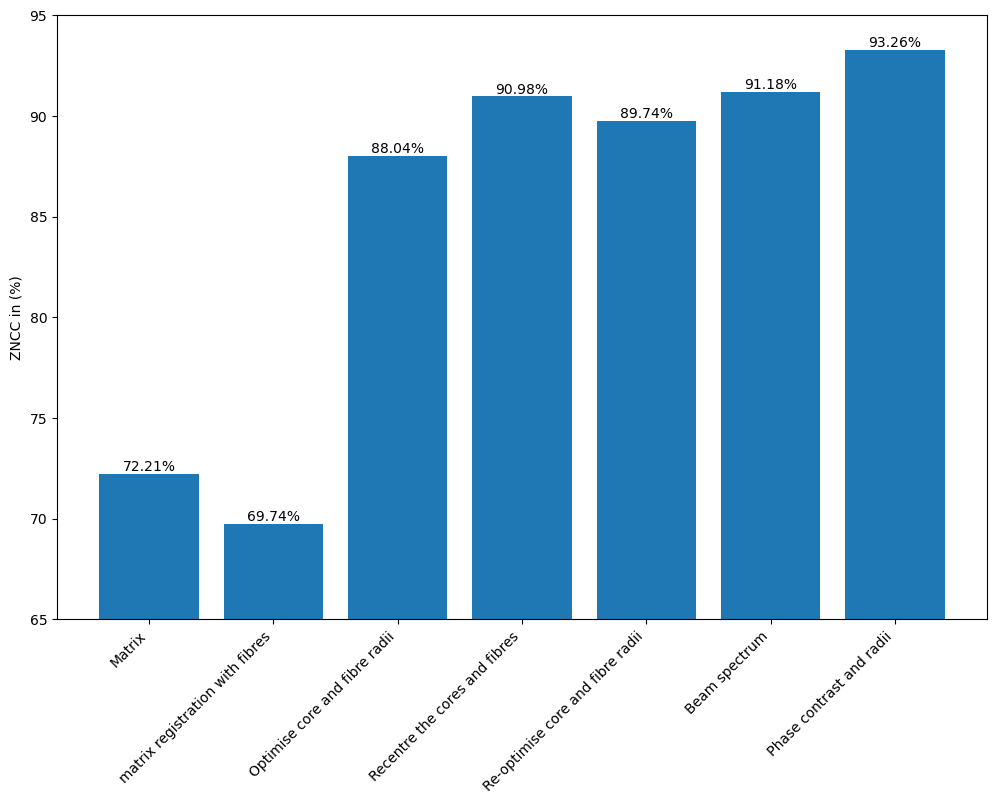

In [91]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

# Optimisation of the phase contrast and the LSF

In [92]:
old_lsf = copy.deepcopy(lsf_kernel);

In [93]:
def fitnessFunctionLaplacianLSF(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global lsf_kernel;

    # sigma_core = x[0];
    k_core = x[0];
    # sigma_fibre = x[2];
    k_fibre = x[1];
    # sigma_matrix = x[4];
    k_matrix = x[2];

    b2 = x[3];
    c2 = x[4];
    e2 = x[5];
    f2 = x[6];

    # The response of the detector as the line-spread function (LSF)
    t = np.arange(-20., 21., 1.);
    lsf_kernel=lsf(t*41, b2, c2, e2, f2);
    lsf_kernel/=lsf_kernel.sum();

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = reconstruct(simulated_sinogram)
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        imsave("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".tif",
                simulated_sinogram);
        
        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT);

        np.savetxt("outputs/" + prefix + "laplacian_" + str(best_fitness_id) + ".dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
        np.savetxt("outputs/" + prefix + "LSF_" + str(best_fitness_id) + ".dat", [b2, c2, e2, f2], header='b2, c2, e2, f2');

        
        best_fitness_id += 1;

    return objective;

In [94]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian2.dat") and os.path.isfile("outputs/lsf2.dat"):
    temp = np.loadtxt("outputs/laplacian2.dat");
    k_core = temp[0];
    k_fibre = temp[1];
    k_matrix = temp[2];

    temp = np.loadtxt("outputs/lsf2.dat");
    b2 = temp[0];
    c2 = temp[1];
    e2 = temp[2];
    f2 = temp[3];

# Perform the registration using CMA-ES
else:

    b2 = 54.9359;
    c2 = -3.58452;
    e2 = 6.32561e+09;
    f2 = 1.0;

    x0 = [
        k_core,
        k_fibre,
        k_matrix,
        b2, c2, e2, f2
    ];

    bounds = [
        [
            k_core-500,
            k_fibre-500,
            k_matrix-500,
            b2 - b2 / 4.,
            c2 + c2 / 4.,
            e2 - e2 / 4.,
            f2 - f2/ 4.
        ],
        [
            k_core+500,
            k_fibre+500,
            k_matrix+500,
            b2 + b2 / 4.,
            c2 - c2 / 4.,
            e2 + e2 / 4.,
            f2 + f2/ 4.
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian2_"

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    #opts['seed'] = 987654321;
    # opts['maxiter'] = 5;
    opts['CMA_stds'] = [1250 * 0.2, 1250 * 0.2, 1250 * 0.2,
        b2 * 0.2, -c2 * 0.2, e2 * 0.2, f2 * 0.2];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacianLSF);

    k_core = es.result.xbest[0];
    k_fibre = es.result.xbest[1];
    k_matrix = es.result.xbest[2];

    b2 = es.result.xbest[3];
    c2 = es.result.xbest[4];
    e2 = es.result.xbest[5];
    f2 = es.result.xbest[6];

    np.savetxt("outputs/laplacian2.dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
    np.savetxt("outputs/lsf2.dat", [b2, c2, e2, f2], header='b2, c2, e2, f2');
    
    # Release memory
    del es;

In [95]:
if not os.path.exists("plots/laplacian2_registration.gif"):
    registration_image_set, image = createAnimation("outputs/laplacian2_simulated_CT_",
                'plots/laplacian2_registration.gif');

![](./plots/laplacian2_registration.gif)

## Apply the result of the registration

In [96]:
# The response of the detector as the line-spread function (LSF)
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41, b2, c2, e2, f2);
lsf_kernel/=lsf_kernel.sum();
np.savetxt("outputs/LSF_optimised.txt", lsf_kernel);

In [97]:
# Simulate the corresponding CT aquisition
sigma_set = [sigma_core, sigma_fibre, sigma_matrix];
k_set = [k_core, k_fibre, k_matrix]; 
label_set = ["core", "fibre", "matrix"];

simulated_sinogram_without_noise, normalised_projections_without_noise, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT_without_noise = reconstruct(simulated_sinogram_without_noise)
normalised_simulated_CT = standardisation(simulated_CT_without_noise);

offset1 = 86;
offset2 = reference_CT.shape[0] - offset1;
profile_test_whole_image_without_noise = copy.deepcopy(np.diag(simulated_CT_without_noise[offset1:offset2, offset1:offset2]));

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Phase contrast and LSF")

print("ZNCC Phase contrast and LSF:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC Phase contrast and LSF: 93.79


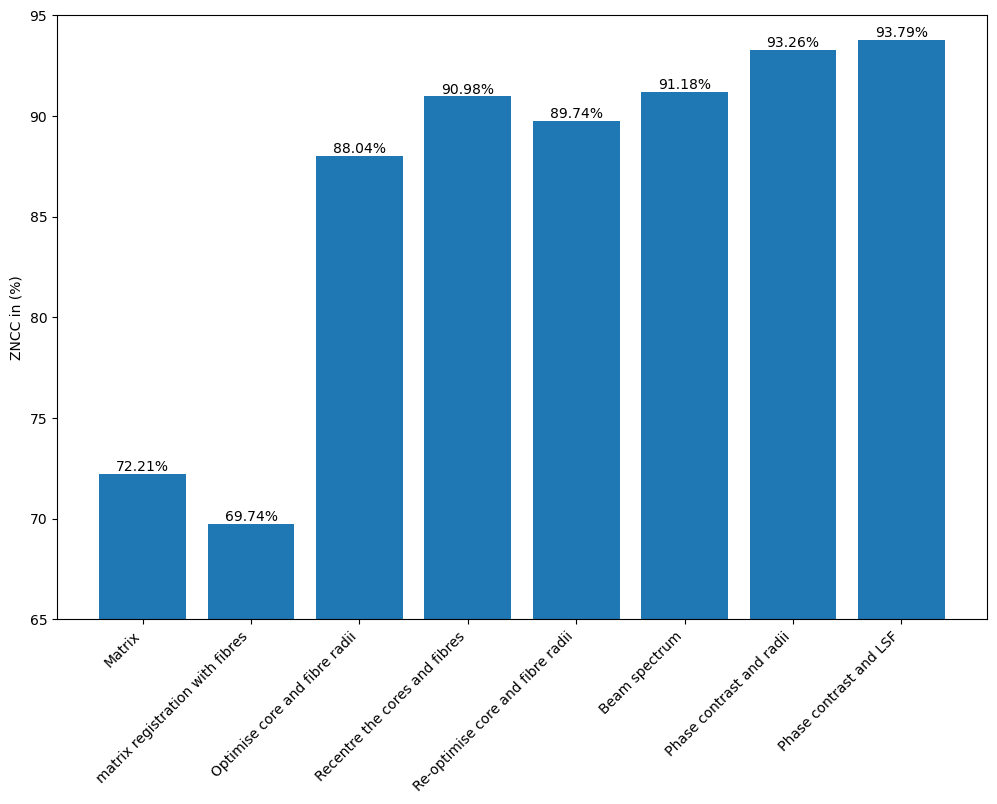

In [98]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

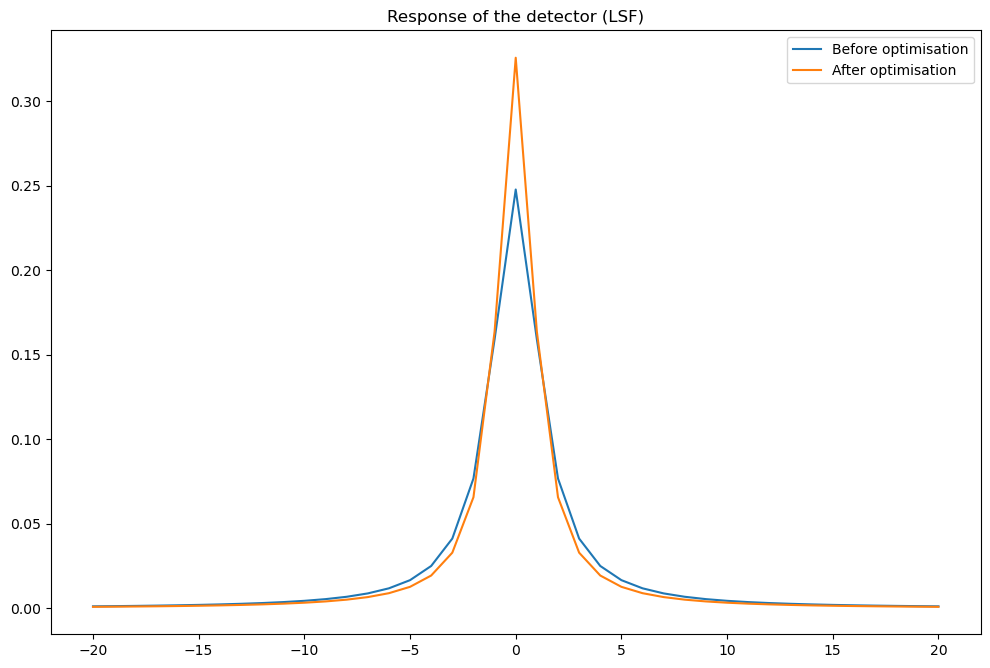

In [99]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, old_lsf, label="Before optimisation");
plt.plot(t, lsf_kernel, label="After optimisation");
plt.legend();
plt.savefig('plots/LSF_optimised.pdf');
plt.savefig('plots/LSF_optimised.png');

# Recentre again

ZNCC Recentre the cores and fibres again: 93.81


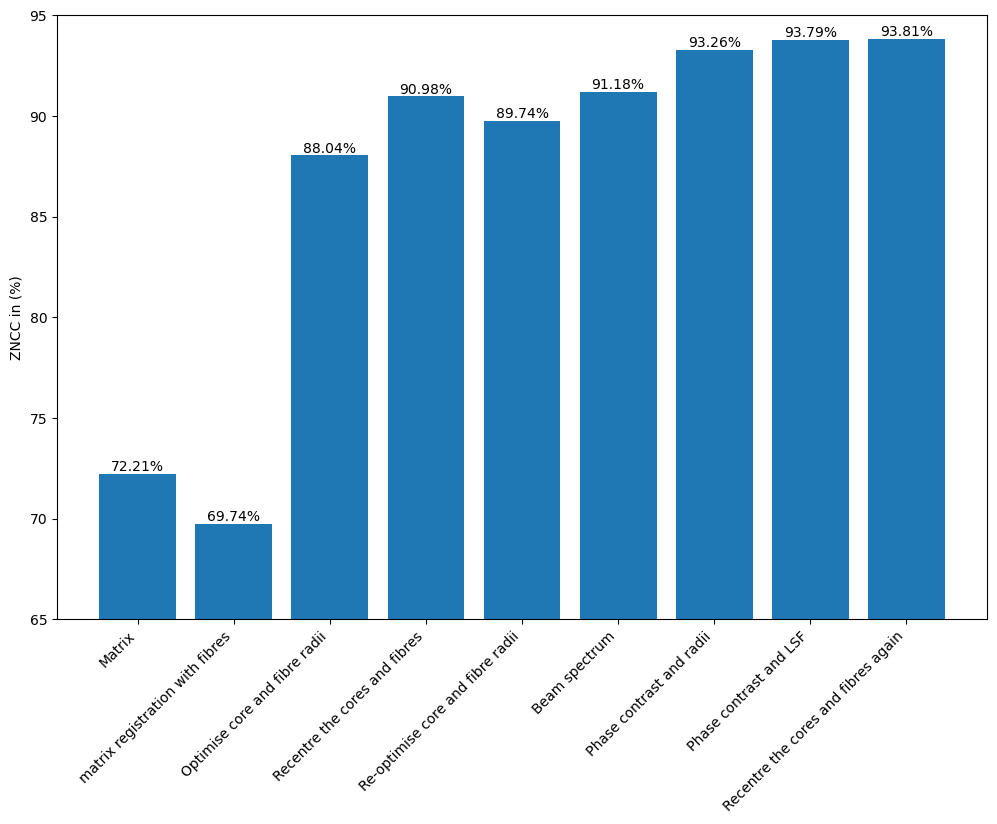

In [100]:
centroid_set = refineCentrePositions(centroid_set, normalised_simulated_CT);

# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = reconstruct(simulated_sinogram)
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Recentre the cores and fibres again")

print("ZNCC Recentre the cores and fibres again:",
      "{:.2f}".format(ZNCC_set[-1]));

plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

## Extract the fibre in the centre of the CT slices

In [101]:
def findFibreInCentreOfCtSlice():
    global centroid_set;
    global reference_CT;
    global cylinder_position_in_centre_of_slice;

    # Find the cylinder in the centre of the image
    cylinder_position_in_centre_of_slice = None;
    best_distance = sys.float_info.max;

    for centre in centroid_set:
        distance = math.pow(centre[0] - reference_CT.shape[1] / 2,2 ) + math.pow(centre[1] - reference_CT.shape[0] / 2, 2);

        if best_distance > distance:
            best_distance = distance;
            cylinder_position_in_centre_of_slice = copy.deepcopy(centre);

    return cylinder_position_in_centre_of_slice;

In [102]:
findFibreInCentreOfCtSlice();

reference_fibre_in_centre = np.array(copy.deepcopy(reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre_without_noise      = np.array(copy.deepcopy(simulated_CT_without_noise[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

profile_reference = copy.deepcopy(np.diag(reference_fibre_in_centre));
profile_test_without_noise = copy.deepcopy(np.diag(test_fibre_in_centre_without_noise));

reference_fibre_in_centre = standardisation(reference_fibre_in_centre);
test_fibre_in_centre_without_noise = standardisation(test_fibre_in_centre_without_noise);

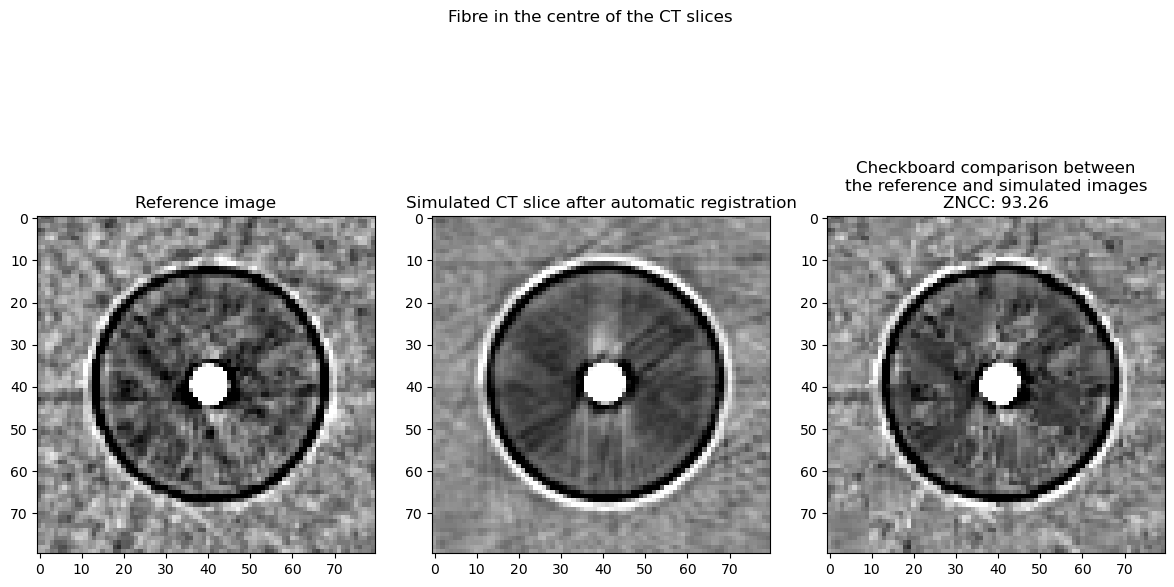

In [103]:
norm2 = cm.colors.Normalize(vmax=1.0, vmin=-1.0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Fibre in the centre of the CT slices')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(reference_fibre_in_centre, cmap="gray", 
                     norm=norm2);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(test_fibre_in_centre_without_noise,
                     cmap='gray',
                     norm=norm2);

comp_equalized = compare_images(reference_fibre_in_centre, test_fibre_in_centre_without_noise, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(reference_fibre_in_centre, test_fibre_in_centre_without_noise))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm2);

plt.savefig('plots/Fibre_in_centre_CT_slices_before_noise.pdf');
plt.savefig('plots/Fibre_in_centre_CT_slices_before_noise.png');

# Optimisation of the Poisson noise

In [104]:
def fitnessFunctionNoise(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    bias = x[0];
    gain = x[1];
    scale = x[2];

    # Poisson noise
    map = (normalised_projections_ROI + (bias + 1)) * gain;
    temp = np.random.poisson(map).astype(float);
    temp /= gain;
    temp -= bias + 1;
    
    # Noise map
    noise_map = normalised_projections_ROI - temp;
    noise_map *= scale;
    noisy_image = normalised_projections_ROI + noise_map;

    # Compute the standard deviation of the pixel values in the ROI extracted from the simulated image with noise
    noisy_image_noise_ROI_stddev = 0;
    for y in range(noisy_image.shape[0]):
        noisy_image_noise_ROI_stddev += noisy_image[y].std();
    noisy_image_noise_ROI_stddev /= noisy_image.shape[0];

    # Difference of std dev between the reference and the simulated image
    diff = reference_noise_ROI_stddev - noisy_image_noise_ROI_stddev;
    objective = diff * diff;
    
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
    
        # Save the simulated CT slice
        imsave("outputs/" + prefix + "noisy_image_" + str(best_fitness_id) + ".tif",
                noisy_image);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [bias, gain, scale], header='bias, gain, scale');
        
        best_fitness_id += 1;

    return objective

In [105]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/poisson-noise.dat"):
    temp = np.loadtxt("outputs/poisson-noise.dat");
    bias = temp[0];
    gain = temp[1];
    scale = temp[2];

# Perform the registration using CMA-ES
else:

    # Extract a ROI from the reference where no object is
    reference_noise_ROI = copy.deepcopy(reference_normalised_projections[450:550,0:125]);

    imsave("outputs/reference_noise_ROI.tif",
           reference_noise_ROI);

    # Compute the standard deviation of the pixel values in the ROI extracted from the reference
    reference_noise_ROI_stddev = 0;
    for y in range(reference_noise_ROI.shape[0]):
        reference_noise_ROI_stddev += reference_noise_ROI[y].std();
    reference_noise_ROI_stddev /= reference_noise_ROI.shape[0];

    # Copy the simulated projection in a temporary variable
    temp = copy.deepcopy(normalised_projections);
    temp.shape = reference_normalised_projections.shape

    # Extract the corresponding ROI
    normalised_projections_ROI = temp[450:550,0:125];

    imsave("outputs/normalised_projections_ROI.tif",
           normalised_projections_ROI);
    
    # Initialise the values
    bias = 0.0;
    gain = 255.0;
    scale = 1;

    x0 = [bias, gain, scale];

    bounds = [
        [-1.0,   0.0, 0.0],
        [ 5.0, 255.0, 255.0]
    ];

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-8);
    opts['tolx'] = 1e-8;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [1, 10, 10];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "poisson-noise_";

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionNoise);

    bias = es.result.xbest[0];
    gain = es.result.xbest[1];
    scale = es.result.xbest[2];

    np.savetxt("outputs/poisson-noise.dat", [bias, gain, scale], header='bias, gain, scale');
    
    # Release memory
    del es;

In [106]:
print("Noise parameters: ", bias, gain, scale)

Noise parameters:  0.26344004400088405 254.594075356281 0.05349773229534583


## Apply the result of the optimisation

In [107]:
# Simulate the corresponding CT aquisition
simulated_sinogram_with_noise, normalised_projections_with_noise, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

In [108]:
# Reconstruct the CT slice
simulated_CT_with_noise = reconstruct(simulated_sinogram_with_noise)
normalised_simulated_CT = standardisation(simulated_CT_with_noise);
# profile_test_whole_image_with_Poisson_noise = copy.deepcopy(np.diag(simulated_CT_with_noise[offset1:offset2, offset1:offset2]));

test_fibre_in_centre_with_noise      = np.array(copy.deepcopy(simulated_CT_with_noise[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_test_with_noise = copy.deepcopy(np.diag(test_fibre_in_centre_with_noise));

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("Poisson noise")

print("ZNCC Poisson noise:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC Poisson noise: 91.11


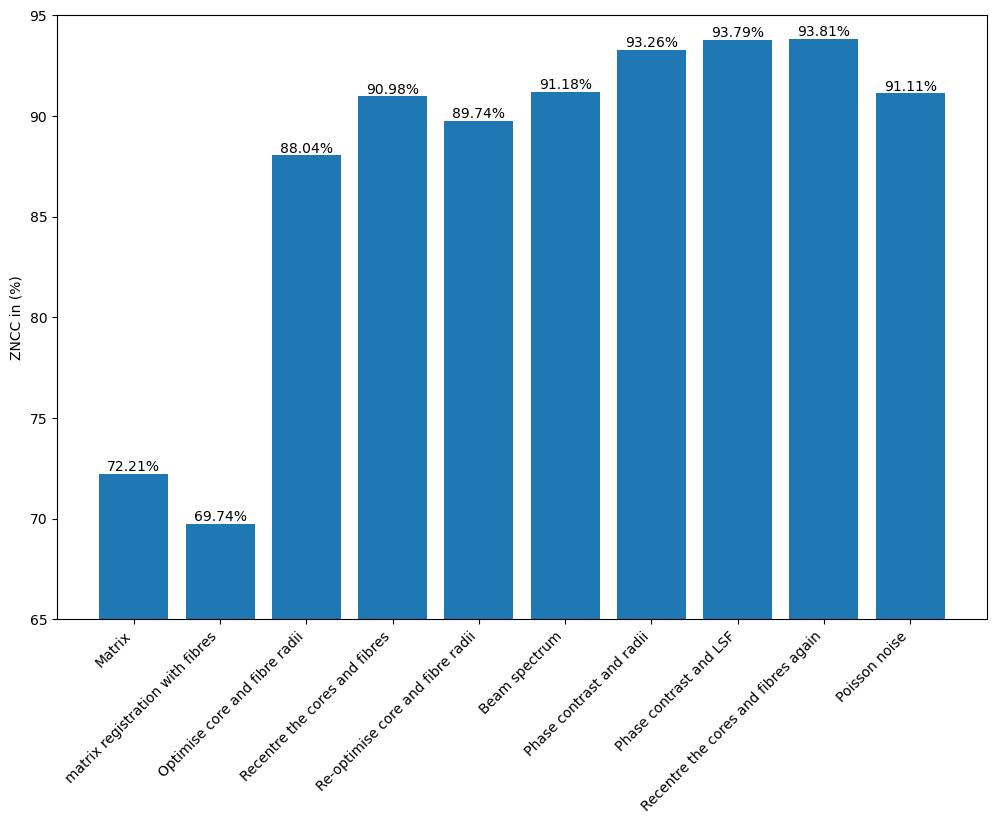

10 10
72.21049666404724 Matrix
69.74347233772278 matrix registration with fibres
88.04264664649963 Optimise core and fibre radii
90.97520709037781 Recentre the cores and fibres
89.73965644836426 Re-optimise core and fibre radii
91.17665886878967 Beam spectrum
93.26246976852417 Phase contrast and radii
93.78882050514221 Phase contrast and LSF
93.80837678909302 Recentre the cores and fibres again
91.1145567893982 Poisson noise


In [109]:
plotSetOfZNCC(ZNCC_set, ZNCC_label_set)

print(len(ZNCC_set), len(ZNCC_label_set))

for zncc, label in zip(ZNCC_set, ZNCC_label_set):
    print(zncc, label)
# ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
# ZNCC_label_set.append("Poisson noise")


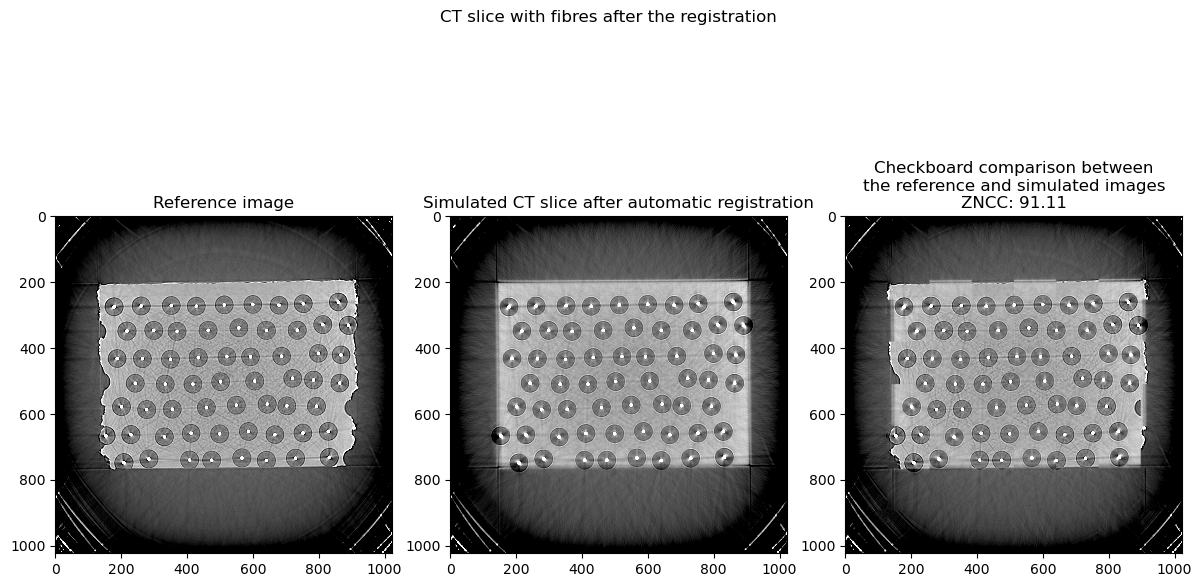

In [110]:
norm2 = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm2);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm2);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm2);

plt.savefig('plots/Fibre_in_centre_CT_slices_after_noise.pdf');
plt.savefig('plots/Fibre_in_centre_CT_slices_after_noise.png');

# Without artefacts

In [111]:
# Disable the LSF
lsf_kernel_bak = copy.deepcopy(lsf_kernel)
lsf_kernel = None

# Disable the phase
sigma_set_bak = copy.deepcopy(sigma_set)
sigma_set = None

k_set_bak = copy.deepcopy(k_set)
k_set = None

label_set_bak = copy.deepcopy(label_set)
label_set = None

# Disable the noise
bias_bak = bias
gain_bak = gain
scale_bak = scale
bias = gain = scale = None

# Disable the beam hardening
gvxr.resetBeamSpectrum();
gvxr.addEnergyBinToSpectrum(33, "keV", 1.0)

In [112]:
# Simulate the corresponding CT aquisition
simulated_sinogram_without_artefacts, normalised_projections_without_artefacts, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

In [113]:
# Restore artefact parameters
lsf_kernel = lsf_kernel_bak

sigma_set = sigma_set_bak
k_set = k_set_bak
label_set = label_set_bak

bias = bias_bak
gain = gain_bak
scale = scale_bak

gvxr.resetBeamSpectrum();
for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

In [114]:
# Reconstruct the CT slice
simulated_CT_without_artefacts = reconstruct(simulated_sinogram_without_artefacts)
normalised_simulated_CT = standardisation(simulated_CT_without_artefacts);

test_fibre_in_centre_without_artefacts      = np.array(copy.deepcopy(simulated_CT_without_artefacts[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_test_whole_image_without_artefacts = copy.deepcopy(np.diag(test_fibre_in_centre_without_artefacts));

# Compute the ZNCC
ZNCC_set.append(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT)))
ZNCC_label_set.append("No artefacts")

print("ZNCC no artefact:",
      "{:.2f}".format(ZNCC_set[-1]));

ZNCC no artefact: 91.28


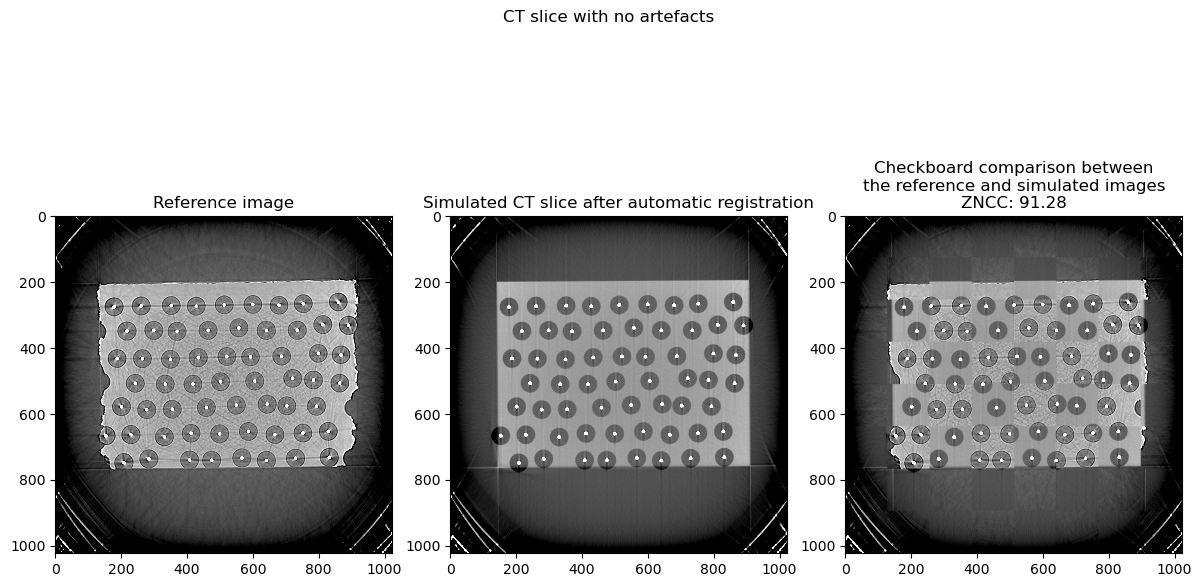

In [115]:
norm2 = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with no artefacts')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm2);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm2);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm2);

plt.savefig('plots/CT_slices_no_artefacts.pdf');
plt.savefig('plots/CT_slices_no_artefacts.png');

In [116]:
# Simulate the corresponding CT aquisition without LSF
lsf_kernel_bak = copy.deepcopy(lsf_kernel)
lsf_kernel = None
simulated_sinogram_without_lsf, normalised_projections_without_lsf, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set)
simulated_CT_without_lsf = reconstruct(simulated_sinogram_without_lsf)
lsf_kernel = lsf_kernel_bak

In [117]:
# Simulate the corresponding CT aquisition without phase
sigma_set_bak = copy.deepcopy(sigma_set)
k_set_bak = copy.deepcopy(k_set)
label_set_bak = copy.deepcopy(label_set)

sigma_set = None
k_set = None
label_set = None

simulated_sinogram_without_phase, normalised_projections_without_phase, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set)
simulated_CT_without_phase = reconstruct(simulated_sinogram_without_phase)

sigma_set = sigma_set_bak
k_set = k_set_bak
label_set = label_set_bak

In [118]:
# Simulate the corresponding CT aquisition without beam hardening

gvxr.resetBeamSpectrum();
gvxr.addEnergyBinToSpectrum(33, "keV", 1.0);

simulated_sinogram_without_beam_hardening, normalised_projections_without_beam_hardening, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set)
simulated_CT_without_beam_hardening = reconstruct(simulated_sinogram_without_beam_hardening)

gvxr.resetBeamSpectrum();
for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

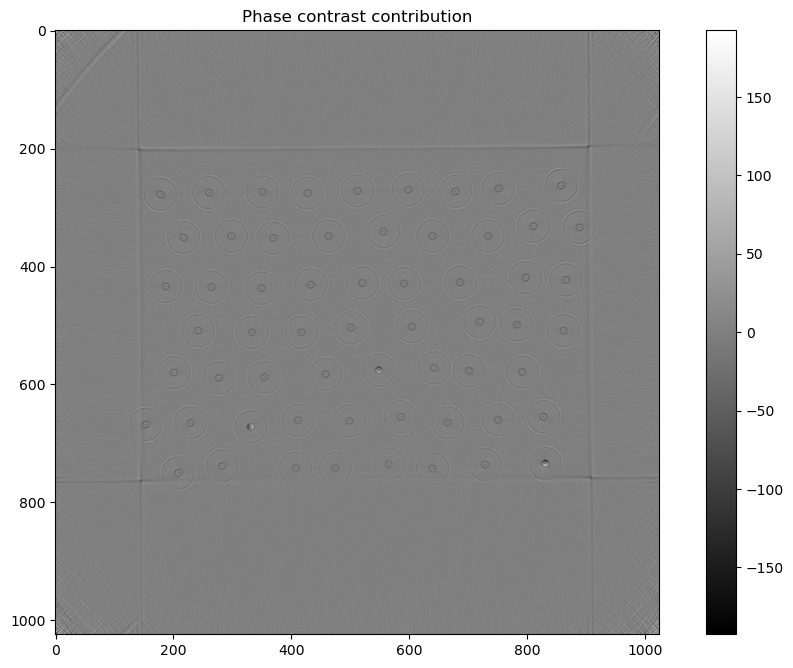

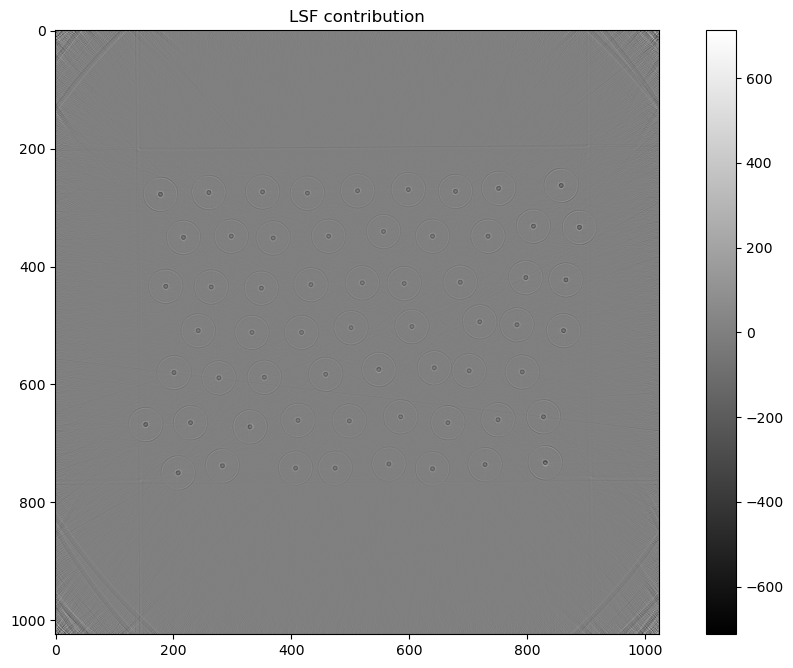

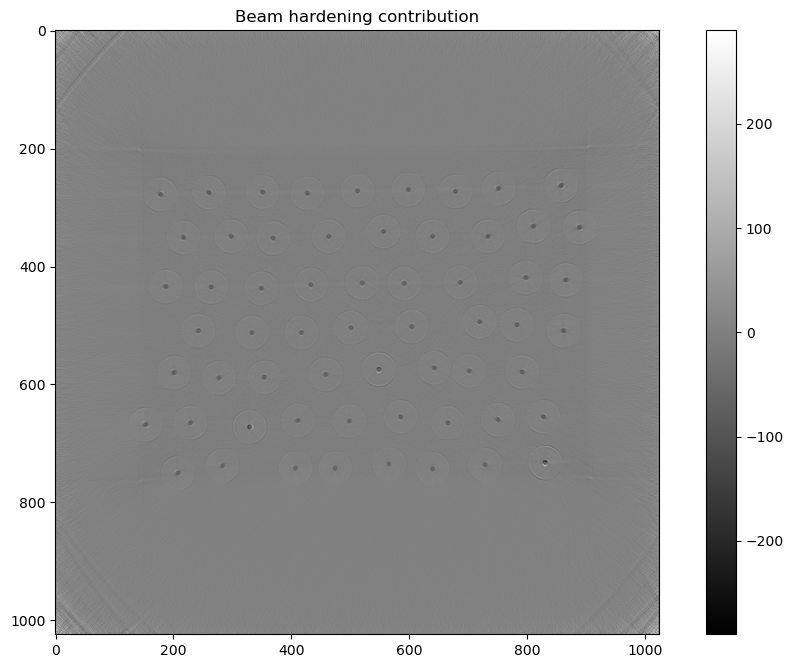

In [119]:
# normalised_projections_with_noise.shape = [900, 1024]
# normalised_projections_without_noise.shape = [900, 1024]
# normalised_projections_without_artefacts.shape = [900, 1024]
# normalised_projections_without_phase.shape = [900, 1024]
# normalised_projections_without_lsf.shape = [900, 1024]
# normalised_projections_without_beam_hardening.shape = [900, 1024]

# phase_contribution = normalised_projections_without_noise - normalised_projections_without_phase
# lsf_contribution = normalised_projections_without_noise - normalised_projections_without_lsf
# beam_hardening_contribution = normalised_projections_without_noise - normalised_projections_without_beam_hardening

phase_contribution = reconstruct(simulated_sinogram_without_noise - simulated_sinogram_without_phase)
lsf_contribution = reconstruct(simulated_sinogram_without_noise - simulated_sinogram_without_lsf)
beam_hardening_contribution = reconstruct(simulated_sinogram_without_noise - simulated_sinogram_without_beam_hardening)

imsave("normalised_projections_without_noise.tif", normalised_projections_without_noise.astype(np.single))
imsave("normalised_projections_without_phase.tif", normalised_projections_without_phase.astype(np.single))
imsave("normalised_projections_without_lsf.tif", normalised_projections_without_lsf.astype(np.single))
imsave("normalised_projections_without_beam_hardening.tif", normalised_projections_without_beam_hardening.astype(np.single))

imsave("phase_contribution.tif", phase_contribution.astype(np.single))
imsave("lsf_contribution.tif", lsf_contribution.astype(np.single))
imsave("beam_hardening_contribution.tif", beam_hardening_contribution.astype(np.single))

plt.figure()
max_abs_val = np.abs(phase_contribution).max()
error_norm = cm.colors.Normalize(vmax=max_abs_val, vmin=-max_abs_val)
plt.title("Phase contrast contribution")
plt.imshow(phase_contribution, cmap="gray", norm=error_norm)
plt.colorbar()

plt.figure()
max_abs_val = np.abs(lsf_contribution).max()
error_norm = cm.colors.Normalize(vmax=max_abs_val, vmin=-max_abs_val)
plt.title("LSF contribution")
plt.imshow((lsf_contribution), cmap="gray", norm=error_norm)
plt.colorbar()

plt.figure()
max_abs_val = np.abs(beam_hardening_contribution).max()
error_norm = cm.colors.Normalize(vmax=max_abs_val, vmin=-max_abs_val)
plt.title("Beam hardening contribution")
plt.imshow((beam_hardening_contribution), cmap="gray", norm=error_norm)
plt.colorbar()

[-57.82437693235829, -24.522985880475392]


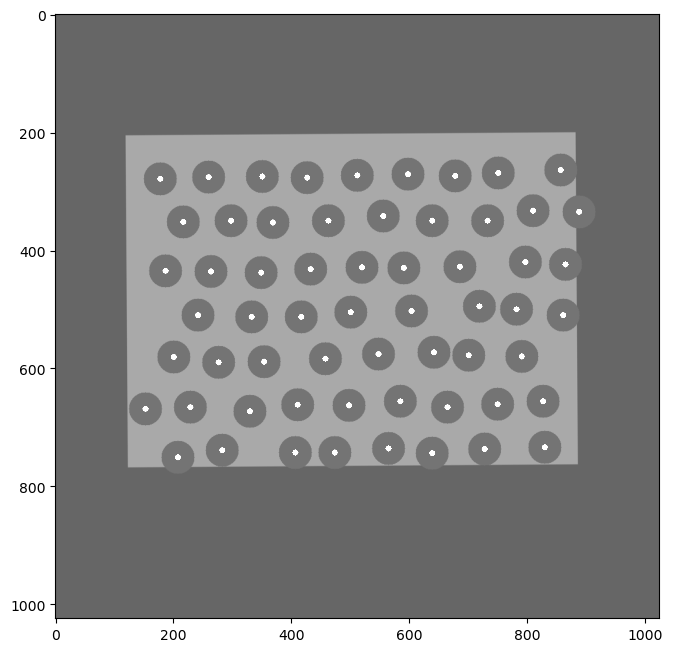

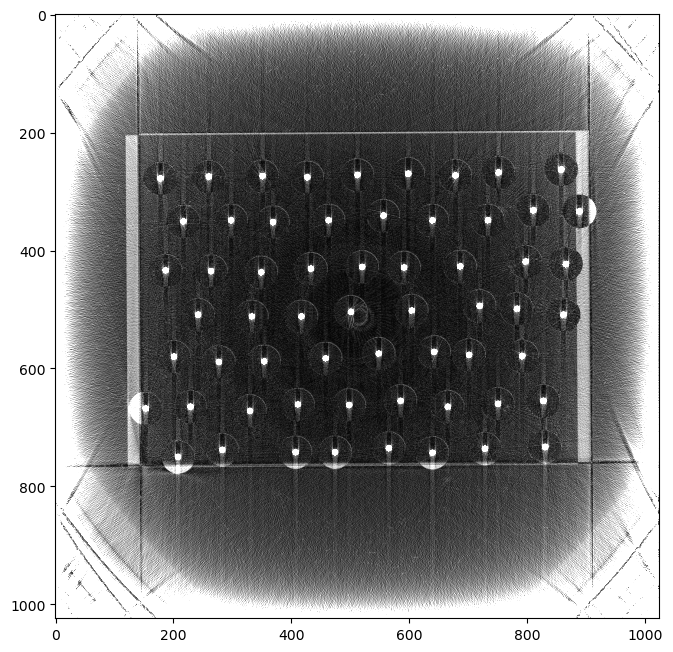

In [120]:
perfect_CT = np.zeros(reference_CT.shape)

print(matrix_centre)
# matrix_centre = [x ,y]
# rotation_angle_in_degrees = (matrix_geometry_parameters[2] + 0.5) * 180.0;
# matrix_size = [w, h]

# from scipy import ndimage

#rotation angle in degree

img_centre = (perfect_CT.shape[0] / 2, perfect_CT.shape[1] / 2)
half_width =  matrix_size[0] / pixel_spacing_in_micrometre / 2
half_height =  matrix_size[1] / pixel_spacing_in_micrometre / 2

perfect_CT = cv2.rectangle(perfect_CT,
              (round(img_centre[0] - half_height), round(img_centre[1] - half_width)),
              (round(img_centre[0] + half_height), round(img_centre[1] + half_width)),
              (13.1274, 13.1274, 13.1274), cv2.FILLED)

perfect_CT = ndimage.rotate(perfect_CT, rotation_angle_in_degrees)
perfect_CT = perfect_CT[0:reference_CT.shape[0], 0:reference_CT.shape[1]]

M = np.float32([
    [1, 0, matrix_centre[1] / pixel_spacing_in_micrometre],
    [0, 1, matrix_centre[0] / pixel_spacing_in_micrometre]
])

perfect_CT = cv2.warpAffine(perfect_CT, M, (perfect_CT.shape[1], perfect_CT.shape[0]))

for centre in centroid_set:
    cv2.circle(perfect_CT, (centre[0], centre[1]), round(fibre_radius / pixel_spacing_in_micrometre), (2.736, 2.736, 2.736), -1)
    cv2.circle(perfect_CT, (centre[0], centre[1]), round(core_radius / pixel_spacing_in_micrometre), (341.61, 341.61, 341.61), -1)

test_fibre_in_centre_perfect_image      = np.array(copy.deepcopy(perfect_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_perfect_image = copy.deepcopy(np.diag(test_fibre_in_centre_perfect_image));

plt.figure()
norm1 = cm.colors.Normalize(vmax=30, vmin=-20)
plt.imshow(perfect_CT, cmap="gray", norm=norm1)

plt.figure()
norm1 = cm.colors.Normalize(vmax=30, vmin=0)
plt.imshow(np.abs(perfect_CT - simulated_CT_without_artefacts), cmap="gray", norm=norm1)

imsave("perfect_CT.tif", perfect_CT.astype(np.single))
#                 341.61,
#                 2.736,
#                 13.1274,

In [121]:
def fitnessCorrection(x):
    
    global best_fitness;
    global best_fitness_id;
    global prefix;

    global reference_normalised_projections
    global phase_contribution
    global lsf_contribution
    global beam_hardening_contribution

    global simulated_sinogram_without_artefacts
    global normalised_projections_without_artefacts
    
    global reference_sinogram

#     #corrected_normalised_projections = normalised_projections_without_noise - \
#     corrected_normalised_projections = reference_normalised_projections - \
#             x[0] * phase_contribution - \
#             x[1] * lsf_contribution

    
#     corrected_sinogram = computeSinogramFromFlatField(corrected_normalised_projections)

#     corrected_sinogram.shape = reference_sinogram.shape

#     # Reconstruct the CT slice
#     corrected_CT = reconstruct(corrected_sinogram)
    
#     imsave("temp.tif",
#         corrected_CT);

#     corrected_CT = simulated_CT_without_noise - \

#             

    corrected_CT = reference_CT - \
            cv2.GaussianBlur(x[0] * phase_contribution, ksize=(0, 0), sigmaX=x[3], sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
            cv2.GaussianBlur(x[1] * lsf_contribution, ksize=(0, 0), sigmaX=x[4], sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
            cv2.GaussianBlur(x[2] * beam_hardening_contribution, ksize=(0, 0), sigmaX=x[5], sigmaY=0, borderType=cv2.BORDER_REFLECT)

#     corrected_CT = reference_CT - \
#         x[0] * lsf_contribution - \
#         x[1] * beam_hardening_contribution

    objective = metrics(perfect_CT, corrected_CT)
#     # Compute the objective value
#     if use_sinogram:
#         objective = metrics(simulated_sinogram_without_artefacts, corrected_sinogram);
#     else:
#         objective = metrics(normalised_projections_without_artefacts, corrected_normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
#         imsave("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".tif",
#                corrected_sinogram.astype(np.single));


#         # Reconstruct the CT slice
#         corrected_sinogram.shape = reference_sinogram.shape
#         corrected_CT = reconstruct(corrected_sinogram)

        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                corrected_CT);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='k1,k2,k3');
    
        best_fitness_id += 1;

    return objective

In [143]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/correction.dat"):
    temp = np.loadtxt("outputs/correction.dat");
    k1 = temp[0];
    k2 = temp[1];
    k3 = temp[2];
    k4 = temp[3];
    k5 = temp[4];
    k6 = temp[5];
    
#     k2 = temp[0];
#     k3 = temp[1];

# Perform the registration using CMA-ES
else:
    x0 = [1.0, 1.0, 1.0, 0.1, 0.1, 0.1];
    bounds = [[1.0, 1.0, 1.0, 0.01, 0.01, 0.01], [5.0, 5.0, 5.0, 2., 2., 2.]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "correction_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-8);
    opts['tolx'] = 1e-8;
    opts['bounds'] = bounds;
    
    use_normalisation = False
    metrics_type = "RMSE"

    es = cma.CMAEvolutionStrategy(x0, 0.025, opts);
    es.optimize(fitnessCorrection);
    k1 = es.result.xbest[0];
    k2 = es.result.xbest[1];
    k3 = es.result.xbest[2];
    k4 = es.result.xbest[3];
    k5 = es.result.xbest[4];
    k6 = es.result.xbest[5];

#     k2 = es.result.xbest[0];
#     k3 = es.result.xbest[1];

    np.savetxt("outputs/correction.dat", [k1, k2, k3, k4, k5, k6], header='k1,k2,k3,k4,k5,k6');
#     np.savetxt("outputs/correction.dat", [k2, k3], header='k2,k3');
    
    # Release memory
    del es;

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=285020, Thu Sep  9 16:04:50 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.603217267431928e+01 1.0e+00 2.58e-02  2e-02  3e-02 0:00.1
    2     18 4.603978997915879e+01 1.4e+00 2.23e-02  2e-02  2e-02 0:00.2
    3     27 4.604392891506472e+01 1.6e+00 2.07e-02  1e-02  2e-02 0:00.3
   31    279 3.468783178415076e+01 5.4e+00 3.46e-01  1e-01  5e-01 0:03.3
   57    513 3.325966816543660e+01 8.2e+00 1.64e-01  4e-02  2e-01 0:07.4
   88    792 3.321941759920396e+01 5.9e+00 1.51e-02  1e-03  8e-03 0:12.4
  100    900 3.321937359881107e+01 5.7e+00 9.42e-03  7e-04  4e-03 0:14.3
  144   1296 3.321936483030733e+01 9.8e+00 3.42e-04  9e-06  7e-05 0:21.3
  196   1764 3.321936480135037e+01 2.1e+01 1.52e-04  4e-06  3e-05 0:29.3
  200   1800 3.321936480715112e+01 2.0e+01 1.83e-04  4e-06  4e-05 0:29.9
  265   2385 3.321936476521784e+01 5.2e+01 1.50e-04  2e-06  2e-05 0:40.0
  300   2700 3.321936478941477e+01 

In [144]:
print("phase:", k1, k4)
print("lsf:", k2, k5)
print("beam hardening:", k3, k6)

phase: 1.0000000065419405 0.7355085218562967
lsf: 1.0000000157761384 1.999999942056732
beam hardening: 1.0000000502355242 1.9999999307426344


In [145]:
corrected_reference_CT = reference_CT - \
        cv2.GaussianBlur(k1 * phase_contribution, ksize=(0, 0), sigmaX=k4, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
        cv2.GaussianBlur(k2 * lsf_contribution, ksize=(0, 0), sigmaX=k5, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
        cv2.GaussianBlur(k3 * beam_hardening_contribution, ksize=(0, 0), sigmaX=k6, sigmaY=0, borderType=cv2.BORDER_REFLECT)

imsave("corrected_reference_CT.tif", corrected_reference_CT.astype(np.single))

corrected_ref_fibre_in_centre = np.array(copy.deepcopy(corrected_reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_corrected_ref = copy.deepcopy(np.diag(corrected_ref_fibre_in_centre));



corrected_test_CT = simulated_CT_without_noise - \
            cv2.GaussianBlur(k1 * phase_contribution, ksize=(0, 0), sigmaX=k4, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
            cv2.GaussianBlur(k2 * lsf_contribution, ksize=(0, 0), sigmaX=k5, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
            cv2.GaussianBlur(k3 * beam_hardening_contribution, ksize=(0, 0), sigmaX=k6, sigmaY=0, borderType=cv2.BORDER_REFLECT)

imsave("corrected_test_CT.tif", corrected_test_CT.astype(np.single))

corrected_test_fibre_in_centre = np.array(copy.deepcopy(corrected_test_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_corrected_test = copy.deepcopy(np.diag(corrected_test_fibre_in_centre));

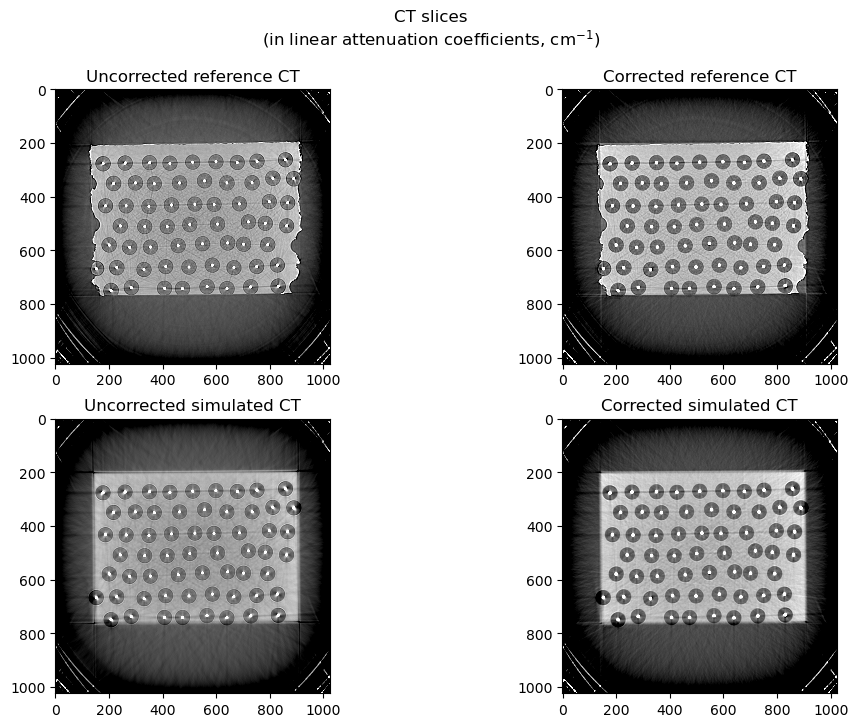

In [149]:
fig, [[ax1, ax2], [ax3, ax4]]=plt.subplots(2,2);

norm = cm.colors.Normalize(vmax=30, vmin=-20)

plt.suptitle("CT slices\n(in linear attenuation coefficients, cm$^{-1}$)")
ax1.set_title("Uncorrected reference CT");
ax2.set_title("Corrected reference CT");
ax3.set_title("Uncorrected simulated CT");
ax4.set_title("Corrected simulated CT");

# plt.savefig('plots/reference_CT_image.pdf');
# plt.savefig('plots/reference_CT_image.png', dpi=10);


imgplot1 = ax1.imshow(reference_CT, cmap="gray", norm=norm);
imgplot2 = ax2.imshow(corrected_reference_CT, cmap="gray", norm=norm);
imgplot3 = ax3.imshow(simulated_CT_without_noise, cmap="gray", norm=norm);
imgplot4 = ax4.imshow(corrected_test_CT, cmap="gray", norm=norm);
# fig.colorbar(imgplot1);

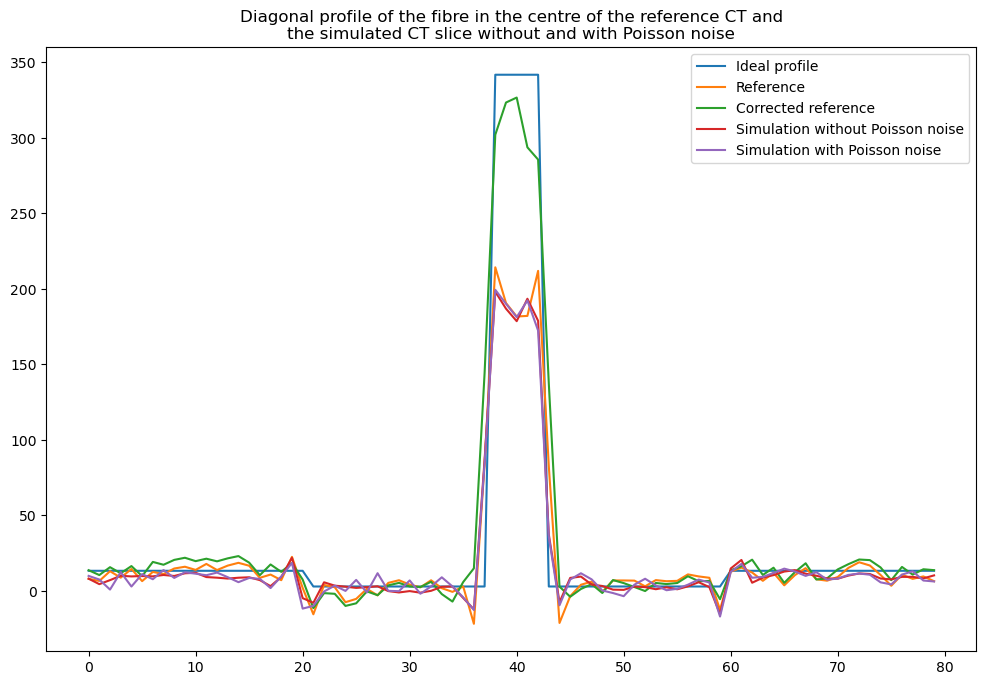

In [150]:
plt.figure()

plt.title("Diagonal profile of the fibre in the centre of the reference CT and\nthe simulated CT slice without and with Poisson noise")

plt.plot(profile_perfect_image, label="Ideal profile");
plt.plot(profile_reference, label="Reference");
plt.plot(profile_corrected_ref, label="Corrected reference");
plt.plot(profile_test_without_noise, label="Simulation without Poisson noise");
plt.plot(profile_test_with_noise, label="Simulation with Poisson noise");


# plt.plot(profile_corrected_test, label="Corrected simulation with artefacts");
plt.legend();
# plt.yscale('log')

plt.savefig('plots/profiles.pdf');
plt.savefig('plots/profiles.png');

In [167]:
%matplotlib widget

plt.rcParams['figure.figsize'] = [10, 5]

# set up plot
fig_corrected, [ax_corrected, ax_uncorrected, ax_prof] =plt.subplots(1, 3);

plt.suptitle("Corrected CT image (in linear attenuation coefficients, cm$^{-1}$)");

ax_corrected.set_title("Corrected")
ax_uncorrected.set_title("Uncorrected")
ax_prof.set_title("Diagonal profiles")

norm = cm.colors.Normalize(vmax=30, vmin=-20)
ax_uncorrected.imshow(reference_CT[512-60:512+61,512-60:512+61], cmap="gray", norm=norm);
 
@widgets.interact(k_phase=(-0., 5., 0.1), k_lsf=(-0., 5., 0.1), k_beam=(-0., 5., 0.1),
                 sigma_phase=(0.01, 10., 0.1), sigma_lsf=(0.01, 10., 0.1), sigma_beam=(0.01, 10., 0.1))
def update(k_phase = k1, k_lsf=k2, k_beam=k3,
          sigma_phase=k4, sigma_lsf=k5, sigma_beam=k6):
#     """Remove old lines from plot and plot new one"""
#     [l.remove() for l in ax.lines]
#     ax.plot(x, my_sine(x, w, amp, phi), color='C0')
    
    corrected_CT = reference_CT - \
        cv2.GaussianBlur(k_phase * phase_contribution, ksize=(0, 0), sigmaX=sigma_phase, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
        cv2.GaussianBlur(k_lsf * lsf_contribution, ksize=(0, 0), sigmaX=sigma_lsf, sigmaY=0, borderType=cv2.BORDER_REFLECT)  - \
        cv2.GaussianBlur(k_beam * beam_hardening_contribution, ksize=(0, 0), sigmaX=sigma_beam, sigmaY=0, borderType=cv2.BORDER_REFLECT)

#     corrected_CT = reference_CT - \
#         k_phase * phase_contribution - \
#         k_lsf * lsf_contribution - \
#         k_beam * beam_hardening_contribution

    corrected_imgplot = ax_corrected.imshow(corrected_CT[512-60:512+61,512-60:512+61], cmap="gray", norm=norm);
#     fig_corrected.colorbar(corrected_imgplot);

    

    corrected_ref_fibre_in_centre = np.array(copy.deepcopy(corrected_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
    profile_corrected_ref = copy.deepcopy(np.diag(corrected_ref_fibre_in_centre));

    while len(ax_prof.lines):
        ax_prof.lines.remove(ax_prof.lines[0])

    
    ax_prof.plot(profile_perfect_image, color='b', label="Ideal");
    ax_prof.plot(profile_reference, color='orange', label="Uncorrected");
    ax_prof.plot(profile_corrected_ref, color='g', label="Corrected");
#     ax_prof.plot(profile_test_without_noise, color='red', label="Simulation without Poisson noise");
#     ax_prof.plot(profile_test_with_noise, color='yellow', label="Simulation with Poisson noise");

    ax_prof.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                   fancybox=True, shadow=True, ncol=3)
    #     ax_prof.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0000000065419405, description='k_phase', max=5.0), FloatSlider(value…

In [168]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Results in terms of linear attenuation coefficients

Reduce the ROI size to focus on a single fibre and its surrounding matrix

In [169]:
roi_length = 40

Extract the ROIs

In [170]:
reference_fibre_in_centre = np.array(copy.deepcopy(reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre_with_noise = np.array(copy.deepcopy(simulated_CT_with_noise[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre_without_artefacts = np.array(copy.deepcopy(simulated_CT_without_artefacts[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

corrected_reference_fibre_in_centre = np.array(copy.deepcopy(corrected_reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
corrected_test_fibre_in_centre = np.array(copy.deepcopy(corrected_test_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

A function to create a circular binary mask

In [171]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return np.array(mask, dtype=bool);

A function to create the binary masks for the core, fibre and matrix

In [172]:
def createMasks(mask_shape):
    fibre_radius_in_px = fibre_radius / pixel_spacing_in_micrometre
    core_radius_in_px = core_radius / pixel_spacing_in_micrometre

    core_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, core_radius_in_px);

    fibre_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, fibre_radius_in_px);
    matrix_mask = np.logical_not(fibre_mask);

    #fibre_mask = np.subtract(fibre_mask, core_mask);
    fibre_mask = np.bitwise_xor(fibre_mask, core_mask);

    #TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

    return core_mask, fibre_mask, matrix_mask

Create binary masks for the core, fibre and matrix

In [173]:
mask_shape = reference_fibre_in_centre.shape;
core_mask, fibre_mask, matrix_mask = createMasks(mask_shape);

core_mask = ndimage.binary_erosion(core_mask).astype(core_mask.dtype);

for i in range(4):
    fibre_mask = ndimage.binary_erosion(fibre_mask).astype(fibre_mask.dtype);
    matrix_mask = ndimage.binary_erosion(matrix_mask, border_value=1).astype(matrix_mask.dtype);

core_mask.shape = [core_mask.shape[0], core_mask.shape[1]]
fibre_mask.shape = [fibre_mask.shape[0], fibre_mask.shape[1]]
matrix_mask.shape = [matrix_mask.shape[0], matrix_mask.shape[1]]


Display the masks

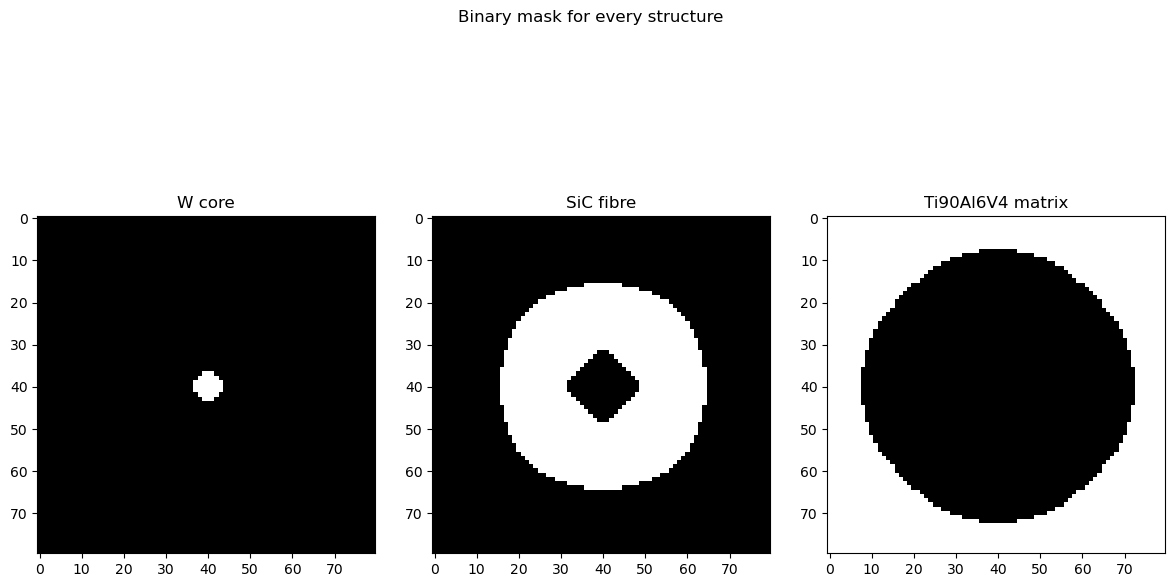

In [174]:
norm = cm.colors.Normalize(vmax=1, vmin=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Binary mask for every structure')

ax1.set_title("W core");
imgplot1 = ax1.imshow(core_mask, cmap="gray", 
                     norm=norm);

ax2.set_title("SiC fibre");
imgplot2 = ax2.imshow(fibre_mask,
                     cmap='gray',
                     norm=norm);

ax3.set_title("Ti90Al6V4 matrix");
imgplot3 = ax3.imshow(matrix_mask,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/masks.pdf');
plt.savefig('plots/masks.png');

A function to collect all the $\mu$ statistics from the masks.

In [175]:
def getMuStatistics(reference_fibre_in_centre,
                    corrected_reference_fibre_in_centre,
                    test_fibre_in_centre_with_noise,
                    core_mask, fibre_mask, matrix_mask):

    data = [];
    index = np.nonzero(core_mask);
    
    data.append(["Theorical", 
                "Core", 
                "W", 
                341.61,
                341.61, #gvxr.getLinearAttenuationCoefficient("core", 33, "keV"),
                341.61,
                0.0,
                "N/A"]);

    data.append(["Experimental (corrected)", 
                "", #"Core", 
                "", #"W", 
                np.min(corrected_reference_fibre_in_centre[index]),
                np.max(corrected_reference_fibre_in_centre[index]),
                np.mean(corrected_reference_fibre_in_centre[index]),
                np.std(corrected_reference_fibre_in_centre[index]),
                341.61 - np.mean(corrected_reference_fibre_in_centre[index])]);

    data.append(["Experimental", 
                "", #"Core", 
                "", #"W", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index]),
                341.61 - np.mean(reference_fibre_in_centre[index])]);
    
    data.append(["Simulation", 
                "", #"Core", 
                "", #"W", 
                np.min(test_fibre_in_centre_with_noise[index]),
                np.max(test_fibre_in_centre_with_noise[index]),
                np.mean(test_fibre_in_centre_with_noise[index]),
                np.std(test_fibre_in_centre_with_noise[index]),
                341.61 - np.mean(test_fibre_in_centre_with_noise[index])]);

    index = np.nonzero(fibre_mask);

    data.append(["Theorical", 
                "Fibre", 
                "SiC", 
                2.736, #gvxr.getLinearAttenuationCoefficient("fibre", 33, "keV"),
                2.736,
                2.736,
                0.0,
                "N/A"]);
    
    data.append(["Experimental (corrected)", 
                "", #"Fibre", 
                "", #"SiC", 
                np.min(corrected_reference_fibre_in_centre[index]),
                np.max(corrected_reference_fibre_in_centre[index]),
                np.mean(corrected_reference_fibre_in_centre[index]),
                np.std(corrected_reference_fibre_in_centre[index]),
                2.736 - np.mean(corrected_reference_fibre_in_centre[index])]);

    data.append(["Experimental", 
                "", #"Fibre", 
                "", #"SiC", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index]),
                2.736 - np.mean(reference_fibre_in_centre[index])]);
    
    data.append(["Simulation", 
                "", #"Fibre", 
                "", #"SiC", 
                np.min(test_fibre_in_centre_with_noise[index]),
                np.max(test_fibre_in_centre_with_noise[index]),
                np.mean(test_fibre_in_centre_with_noise[index]),
                np.std(test_fibre_in_centre_with_noise[index]),
                2.736 - np.mean(test_fibre_in_centre_with_noise[index])]);

    index = np.nonzero(matrix_mask);
    data.append(["Theorical", 
                "Matrix", 
                "Ti90Al6V4", 
                13.1274, #gvxr.getLinearAttenuationCoefficient("matrix", 33, "keV"),
                13.1274,
                13.1274,
                0.0,
                "N/A"]);

    data.append(["Experimental (corrected)", 
                "", #"Matrix", 
                "", #"Ti90Al6V4", 
                np.min(corrected_reference_fibre_in_centre[index]),
                np.max(corrected_reference_fibre_in_centre[index]),
                np.mean(corrected_reference_fibre_in_centre[index]),
                np.std(corrected_reference_fibre_in_centre[index]),
                13.1274 - np.mean(corrected_reference_fibre_in_centre[index])]);

    data.append(["Experimental", 
                "", #"Matrix", 
                "", #"Ti90Al6V4", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index]),
                13.1274 - np.mean(reference_fibre_in_centre[index])]);
    
    data.append(["Simulation", 
                "", #"Matrix", 
                "", #"Ti90Al6V4", 
                np.min(test_fibre_in_centre_with_noise[index]),
                np.max(test_fibre_in_centre_with_noise[index]),
                np.mean(test_fibre_in_centre_with_noise[index]),
                np.std(test_fibre_in_centre_with_noise[index]),
                13.1274 - np.mean(test_fibre_in_centre_with_noise[index])]);
    
    return pd.DataFrame(data,
            index=None,
            columns=['CT', 'Structure', "Composition", 'min', 'max', 'mean', 'stddev', 'error'])

Get the dataframe with all the values and display it as a table

In [176]:
df = getMuStatistics(reference_fibre_in_centre,
                     corrected_reference_fibre_in_centre,
                     test_fibre_in_centre_with_noise,
                     core_mask, fibre_mask, matrix_mask);

display(df)

df.to_csv("attenuation.csv")

CT Structure Composition         min         max  \
0                  Theorical      Core           W  341.610000  341.610000   
1   Experimental (corrected)                        230.035568  331.364716   
2               Experimental                        164.904282  216.003738   
3                 Simulation                         96.473763  204.764725   
4                  Theorical     Fibre         SiC    2.736000    2.736000   
5   Experimental (corrected)                        -14.399358   19.610744   
6               Experimental                        -12.661861   19.978802   
7                 Simulation                        -16.754343   21.532127   
8                  Theorical    Matrix   Ti90Al6V4   13.127400   13.127400   
9   Experimental (corrected)                          0.187844   28.149023   
10              Experimental                         -3.223267   23.797626   
11                Simulation                         -2.204352   21.172808   

          mean     stddev       error  
0   341.610000   0.000000         N/A  
1   294.173309  25.936420   47.436691  
2   193.974426  11.853712  147.635574  
3   177.299515  27.441103  164.310485  
4     2.736000   0.000000         N/A  
5     1.189618   4.867199    1.546382  
6     3.227235   4.698780   -0.491235  
7     2.216340   4.168764     0.51966  
8    13.127400   0.000000         N/A  
9    15.056427   4.573271   -1.929027  
10   10.649131   4.099542    2.478269  
11    9.738307   3.534829    3.389093

# Save the CAD models and plot them in 3D

In [177]:
gvxr.saveSTLfile("fibre", "outputs/final_SiC_fibres.stl");
gvxr.saveSTLfile("core",  "outputs/final_W_cores.stl");
gvxr.saveSTLfile("matrix", "outputs/final_Ti90Al6V4_matrix.stl");

In [178]:
np.savetxt("outputs/centroids.dat", centroid_set);

Load the STL files

In [179]:
fibre_mesh = mesh.Mesh.from_file('outputs/final_SiC_fibres.stl')
core_mesh = mesh.Mesh.from_file('outputs/final_W_cores.stl')
matrix_mesh = mesh.Mesh.from_file('outputs/final_Ti90Al6V4_matrix.stl')

Create the k3d geometries

In [180]:
matrix_geometry = k3d.mesh(matrix_mesh.vectors.flatten(),
                          range(int(matrix_mesh.vectors.flatten().shape[0] / 3)),
                          color=0x7fc97f, 
                          wireframe=False, 
                          flat_shading=False,
                          name="Ti90Al6V4 Matrix",
                          opacity = 0.4)
    
fibres_geometry = k3d.mesh(fibre_mesh.vectors.flatten(),
                          range(int(fibre_mesh.vectors.flatten().shape[0] / 3)),
                          color=0xbeaed4, 
                          wireframe=False, 
                          flat_shading=False,
                          name="SiC Fibres",
                          opacity = 0.9)

cores_geometry = k3d.mesh(core_mesh.vectors.flatten(),
                         range(int(core_mesh.vectors.flatten().shape[0] / 3)),
                         color=0xfdc086, 
                         wireframe=False, 
                         flat_shading=False,
                         name="W Cores",
                          opacity = 0.4)

In [181]:
plot = k3d.plot()
plot.background_color = 0xffffff

plot += matrix_geometry
plot += fibres_geometry
plot += cores_geometry

plot.display()

Output()